In [1]:
import numpy as np
import time
from math import sqrt, pi, exp
import functools
import scipy
from varname import nameof


from utils.preconditioners import *
from utils.mog_functions import *
from utils.functions import *

In [2]:
#### functions for the MOG case


# parameters of the mixture 


from scipy.stats import multivariate_normal


# target density
def bimodal_distribution(z, gap = 8, sigma1 = 1, sigma2 = 1):
    # Bimodal distribution probability density function
    mean1 = [-gap/2, 0]
    cov1 = [[sigma1, 0], [0, sigma1]]
    pdf1 = multivariate_normal(mean1, cov1).pdf(z)

    mean2 = [gap/2, 0]
    
    cov2 = [[sigma2, 0], [0, sigma2]]
    pdf2 = multivariate_normal(mean2, cov2).pdf(z)

    outcome= 0.5 * pdf1 + 0.5 * pdf2
    return outcome


# target potential
def potential(z):
    return -np.log(bimodal_distribution(z))

# target potential 2
I = lambda u: potential(np.stack((u[0],u[1]),axis=-1))


#not vectorized
def gradient_of_log_bimodal_distribution(z,  gap = 8, sigma1 = 1, sigma2 = 1):

    mean1 = np.asarray([-gap/2, 0])
    cov1 = [[sigma1, 0], [0, sigma1]]
    pdf1 = multivariate_normal(mean1, cov1).pdf(z) 
    

    mean2 = np.asarray([gap/2, 0])
    cov2 = [[sigma2, 0], [0, sigma2]]
    pdf2 = multivariate_normal(mean2, cov2).pdf(z)

    gradient= -  (1/(bimodal_distribution(z)))*(0.5*pdf1*np.matmul(np.linalg.inv(cov1),(z - mean1))\
                                                     +0.5*pdf2*np.matmul(np.linalg.inv(cov2),(z - mean2)))
    return gradient



######################################
#              MOG Case              #
######################################


def run_ULA_mog(potential, N_sim, u0, tau, grad_inference = gradient_of_log_bimodal_distribution):
    
    d, J  = u0.shape
    us_list_ULA = np.zeros((d, J, N_sim)) 
    us_list_ULA[:,:,0] = u0 
    
    for n in range(N_sim-1):    
        us = us_list_ULA[:,:,n]
        
        vs = np.zeros_like(us)
        for i in range(us.shape[1]):
            test = gradient_of_log_bimodal_distribution(us[:, i])
            vs[:, i] +=  gradient_of_log_bimodal_distribution(us[:, i])

        us_list_ULA[:,:,n+1] = us_list_ULA[:,:,n] + tau*vs \
            + np.sqrt(2*tau)*np.random.normal(0,1,(d,J))

    return us_list_ULA


# true_square_root = False: ALDI with nonsymmetric square root of C
def run_ALDI_with_gradient_mog(potential, N_sim, u0, tau, true_square_root = False, grad_inference = gradient_of_log_bimodal_distribution):
    
    d, J = u0.shape
    us_list_ALDI = np.zeros((d,J,N_sim))
    us_list_ALDI[:,:,0] = u0
    
    for n in range(N_sim-1):   
        
        us = us_list_ALDI[:,:,n]
        m_us = np.mean(us, axis=1)[:,np.newaxis]
        u_c = us - m_us 
        C = np.cov(us) * (J-1)/J 
        
        vs = np.zeros_like(us)
        for i in range(us.shape[1]):
            test = gradient_of_log_bimodal_distribution(us[:, i])#.reshape((2,1))
            vs[:, i] +=  gradient_of_log_bimodal_distribution(us[:, i])#.reshape((2,1))
        
        drift = + np.dot(C,vs) + (d+1)*1/J*(us-m_us) 
        
        if not true_square_root: 
            Csqrt = 1/np.sqrt(J) * u_c
            noise = np.random.normal(0,1,(J,J))
            diff = np.sqrt(2)*Csqrt@noise
        
        else: 
            sqrtC = scipy.linalg.sqrtm(C)
            noise = np.random.normal(0,1,(2,J))
            diff = np.sqrt(2) * np.dot(sqrtC,noise)
        
    
        us_list_ALDI[:,:,n+1] = us + tau * drift  + np.sqrt(tau) * diff

    return us_list_ALDI


# our scheme. with true square root of D, also without the corrective term of Nuesken
def run_ALDINR_mog(potential, N_sim, u0, tau, const, grad_inference = gradient_of_log_bimodal_distribution):

    d, J = u0.shape    
    us_list_ALDINR = np.zeros((d,J,N_sim))
    us_list_ALDINR[:,:,0] = u0
    
    # to track the convergence
    #preconditioners = np.ones((d, d, N_sim)) # product of (D_opt+J_opt)K^{-1}
    #preconditioners[:, :, 0] = np.cov(u0)*(J-1)/J
    
    for n in range(N_sim-1): 
        
        us = us_list_ALDINR[:,:,n] # shape (d, J)
        m_us = np.mean(us, axis=1)[:,np.newaxis] # shape (2, 1)
        C = np.cov(us)*(J-1)/J # shape (2,2)

        # compute sqrt C
        sqrtC = scipy.linalg.sqrtm(C)
        
        # compute D
        D_opt_tilde, v, lambda_min = construct_D_opt_tilde(C,d)
        if lambda_min> 500:
            print("ALDINR diverging")
            
        D_opt = construct_D_opt(C,d)

        if np.mod(n, 500) == 0:
            print("iter")
            print(n)
            print("lambda min")
            print(lambda_min)
            #print(C)
            
        # compute psis
        psis = construct_onb(d, v)
        
        # compute sqrt D
        sqrtD = scipy.linalg.sqrtm(D_opt) # we should be able to do something cheap here
        
        # compute J opt
        J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtC)
        
        T = J_opt +D_opt
        
        vs = np.zeros_like(us)
        for i in range(us.shape[1]):
            test = gradient_of_log_bimodal_distribution(us[:, i])#.reshape((2,1))
            vs[:, i] +=  gradient_of_log_bimodal_distribution(us[:, i])#.reshape((2,1))
        
        drift = + np.dot(T, vs) 
        noise = np.random.normal(0,1,(2,J))
        diff = np.sqrt(2) * np.dot(sqrtD,noise) 
        
        
        us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff 
        
        # keep record of some stats
        #preconditioners[:, :, n] = T
        
    return us_list_ALDINR #, preconditioners

### Test case "Mixture of Gaussians" - 1 

(-6.0, 6.0, -6.0, 6.0)

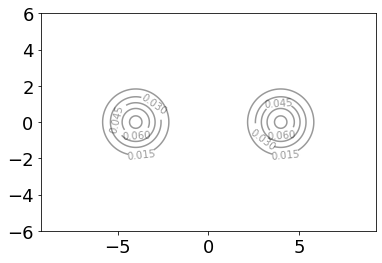

In [3]:
d = 2

val = 6
xmin = -val
xmax = val
ymin= -val
ymax= val

# parameters of the mixture 
sigma1 = 1
sigma2 = 1
gap = 4


nb_grid = 200

# plot posterior
u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U0, U1 = np.meshgrid(u0s,u1s) # each of the Ui's is of size (200, 200) (all X coordinates of points parallel to Y axis and reverse)
U = np.dstack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = bimodal_distribution(U) #np.exp(-I1(U)) + np.exp(-I2(U))

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z 
marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

plt.figure()
DS = plt.contour(U0, U1, np.exp(-potential(U)), 5, alpha=0.4, colors="black")
plt.clabel(DS, inline=1, fontsize=10) # level sets of target
plt.axis('equal')

gradient
[-0. -0.]


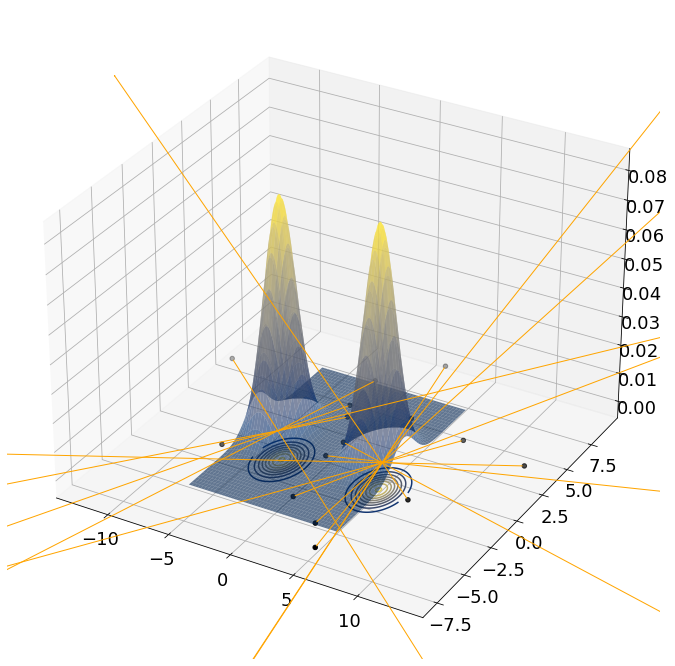

In [4]:

test = np.zeros(2)
print("gradient")
print(gradient_of_log_bimodal_distribution(test))
#plt.figure()
#DS = plt.contour(U0, U1, gradient_of_log_bimodal_distribution(U), 5, alpha=0.4, colors="black") # does not work
# Plot the particles with direction arrows

num_particles = 15
particles = np.random.normal(0, 5, size=(num_particles, d))
grad_particles = np.zeros_like(particles)
for i in range(num_particles):
        for j in range(num_particles):
            grad_particles[i] +=  gradient_of_log_bimodal_distribution(particles[i,:])
#print(grad_particles.shape)

fig = plt.figure(figsize=(20, 12))
#plt.axis("equal")
ax = fig.add_subplot(111, projection='3d')
# Plot the surface of the bimodal distribution
ax.plot_surface(U0, U1, dens, cmap= 'cividis', edgecolor='none', alpha=0.6)

# Create a contour plot in the horizontal plane
ax.contour(U0, U1, dens, levels=8, zdir="z", offset=-0.01, cmap='cividis')
ax.scatter(particles[:, 0], particles[:, 1], np.zeros_like(particles[:, 0]), color='black', label='Particles',zorder=160)


#ax.quiver(particles[:, 0], particles[:, 1], np.zeros_like(particles[:, 0]), grad_particles[:, 0], grad_particles[:, 1], np.zeros_like(particles[:, 0]),
#           color='red', label='Update Direction', alpha=0.8, arrow_length_ratio=0.05,length=5)

# Plot the arrows using Arrow3D
for xi, yi, zi, dxi, dyi, dzi in zip(particles[:, 0], particles[:, 1], np.zeros_like(particles[:, 0]), grad_particles[:, 0], grad_particles[:, 1], np.zeros_like(particles[:, 0])):
    arrow=Arrow3D(xi, yi, zi, xi+dxi, yi+dyi, zi+dzi,mutation_scale=1, arrowstyle='->', lw=1, color='orange',zorder=21,shrinkA=2,shrinkB=2,label='kaas')
    ax.add_artist(arrow)

## Try algorithms

In [5]:
# parameters of all the algorithms

J = 20  # number of particles 
tau = 1e-2 # step size

# parameter of our algorithm (NREKS)
const = 1.5


ULA: 22.129709005355835 seconds
Exact gradient results


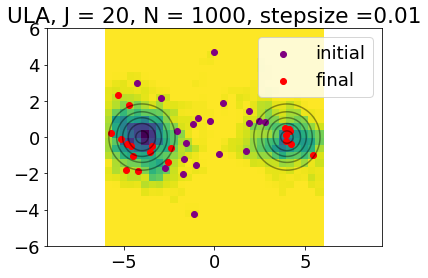

ULA: 15.639287948608398 seconds
Non exact gradient results


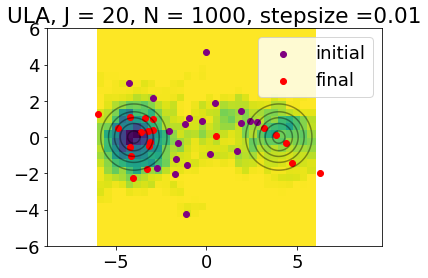

ALDI with gradient: 25.501374006271362 seconds
Exact gradient results


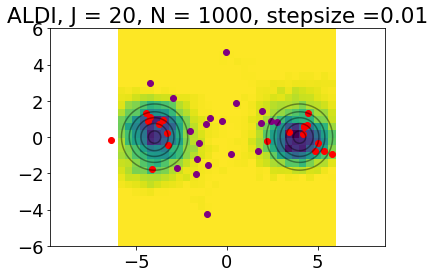

ALDI with gradient: 17.050864934921265 seconds
Non exact gradient results


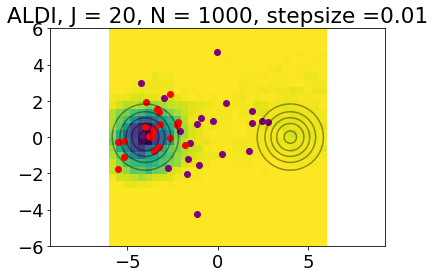

iter
0
lambda min
3.300225022401614


/var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_25757/1336419766.py:169: ComplexWarning: Casting complex values to real discards the imaginary part
  us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


iter
500
lambda min
1.5357790183473468
ALDI NR: 24.647552013397217 seconds
Exact gradient results


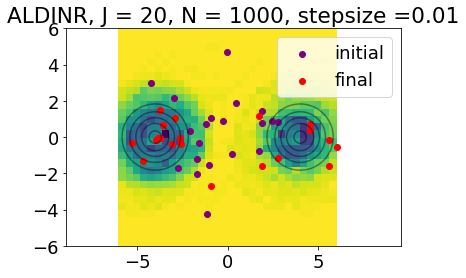

iter
0
lambda min
3.300225022401614


/Users/annakorba/Desktop/nreks/utils/algorithms.py:124: ComplexWarning: Casting complex values to real discards the imaginary part
  us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


iter
500
lambda min
2.1101754099334387
ALDI NR: 17.790706157684326 seconds
Non Exact gradient results


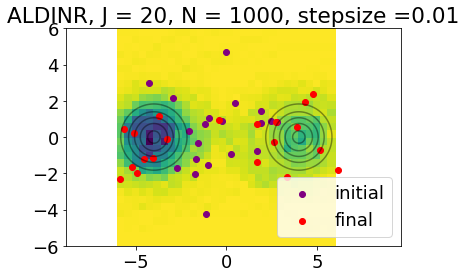

In [6]:
N_sim = 1000

# number of experiments
N_exp = 1

for j in range(N_exp):
    # resample initialization
    u0 = np.random.normal(0,2.0,(d,J)) 
    
    # ULA with exact MOG gradient 
    
    start_time = time.time()
    us_list_ULA = run_ULA_mog(I, N_sim, u0, tau)
    print(f"ULA: {time.time()-start_time} seconds")
    name = nameof(us_list_ULA).lstrip('us_list')
    
    print("Exact gradient results")
    plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()

    # ULA with non exact gradient 
    
    start_time = time.time()
    us_list_ULA = run_ULA(I, N_sim, u0, tau)
    print(f"ULA: {time.time()-start_time} seconds")
    name = nameof(us_list_ULA).lstrip('us_list')
    
    print("Non exact gradient results")
    plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()

    # ALDI with exact MOG gradient
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient_mog(I, N_sim, u0, tau)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")
    name = nameof(us_list_ALDI).lstrip('us_list')
    
    print("Exact gradient results")
    plot_results(I, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red", label = 'final')
    plt.show()
    
     # ALDI with exact MOG gradient
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient(I, N_sim, u0, tau)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")
    name = nameof(us_list_ALDI).lstrip('us_list')
    
    print("Non exact gradient results")
    plot_results(I, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red", label = 'final')
    plt.show()
    
    
    # NRALDI with exact gradients

    start_time = time.time()
    us_list_ALDINR = run_ALDINR_mog(I, N_sim, u0, tau, const) 
    print(f"ALDI NR: {time.time()-start_time} seconds")
    name = nameof(us_list_ALDINR).lstrip('us_list')
    
    print("Exact gradient results")
    plot_results(I, us_list_ALDINR, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()
    
    # NRALDI with non exact gradients

    start_time = time.time()
    us_list_ALDINR = run_ALDINR(I, N_sim, u0, tau, const) 
    print(f"ALDI NR: {time.time()-start_time} seconds")
    name = nameof(us_list_ALDINR).lstrip('us_list')
    
    print("Non Exact gradient results")
    plot_results(I, us_list_ALDINR, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()
    
   

### comment: it seems that for big step size, our scheme crashes only with non exact gradient. Let's try several time with exact gradient:

iter
0
lambda min
2.709375854378942


/var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_25757/1336419766.py:169: ComplexWarning: Casting complex values to real discards the imaginary part
  us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


iter
500
lambda min
2.061410566083658
ALDI NR: 23.998836040496826 seconds
Exact gradient results


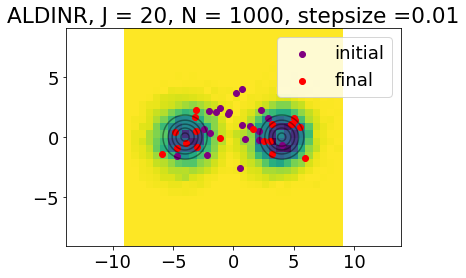

iter
0
lambda min
2.7622772699965594
iter
500
lambda min
0.9016995484002349
ALDI NR: 23.35466980934143 seconds
Exact gradient results


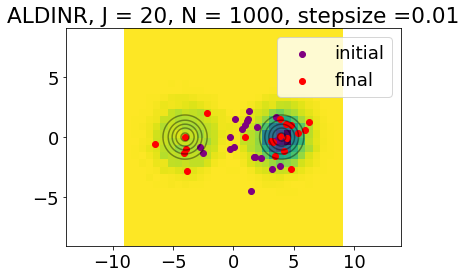

iter
0
lambda min
2.1571582011970376
iter
500
lambda min
1.9897981829126448
ALDI NR: 22.900476217269897 seconds
Exact gradient results


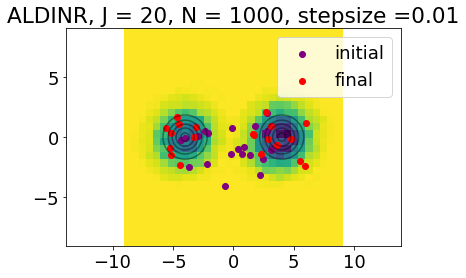

iter
0
lambda min
2.0477703944616468
iter
500
lambda min
1.5489899668640483
ALDI NR: 24.80730128288269 seconds
Exact gradient results


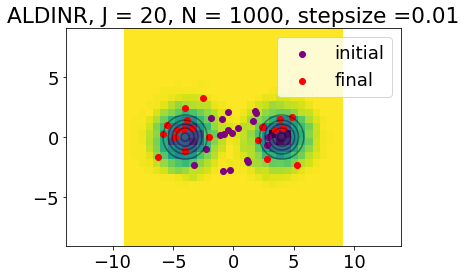

iter
0
lambda min
3.266177504151175
iter
500
lambda min
1.332770328200354
ALDI NR: 24.407620906829834 seconds
Exact gradient results


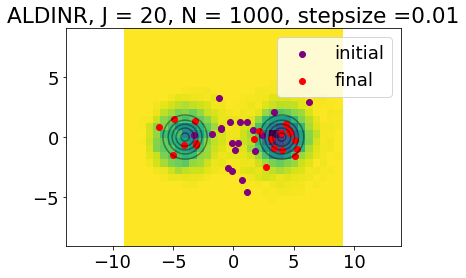

In [7]:
N_sim = 1000

N_exp = 5

for j in range(N_exp):
    # resample initialization
    u0 = np.random.normal(0,2.0,(d,J)) 
 
    # NRALDI with exact gradients

    start_time = time.time()
    us_list_ALDINR = run_ALDINR_mog(I, N_sim, u0, tau, const) 
    print(f"ALDI NR: {time.time()-start_time} seconds")
    name = nameof(us_list_ALDINR).lstrip('us_list')
    
    print("Exact gradient results")
    plot_results(I, us_list_ALDINR, tau, name, xmin =  -val*1.5, xmax = val*1.5, ymin = -val*1.5, ymax = val*1.5)
    plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()
    

### Mixture of Gaussians 2 

(-6.0, 6.0, -6.0, 6.0)

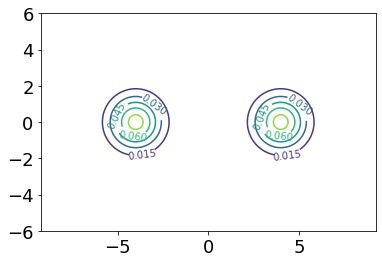

In [9]:
# with a bigger gap we may have to take a smaller stepsize so that it does not crash

d = 2
y = np.zeros(1)
val = 6
xmin = -val
xmax = val
ymin= -val
ymax= val


# potential function
sigma = 1
gap = 8

# potential function
nb_grid = 200

m1 = np.asarray([-1, 0]).reshape((2,1))
m2 = np.asarray([1, 0]).reshape((2,1))

I1 = lambda u: 0.5/(sigma**2)*((u[0] - gap/2)**2 + u[1]**2) # TODO: recoder ça bien
I2 = lambda u: 0.5/(sigma**2)*((u[0] + gap/2)**2 + u[1]**2)

I = lambda u: - np.log(np.exp(-I1(u)) + np.exp(-I2(u)))


# plot posterior

u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U = np.meshgrid(u0s,u1s)
#U = np.stack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = np.exp(-I1(U)) + np.exp(-I2(U))

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z # check the computation
#dens = unnorm_dens

marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

plt.figure()
DS = plt.contour(U0, U1, dens) # plot normalized density  
plt.clabel(DS, inline=1, fontsize=10)
labels = ['post', 'post','post','post','post', 'post']
for i in range(len(labels)):
    DS.collections[i].set_label(labels[i])
plt.axis('equal')



Experiment 1
ULA: 23.418442010879517 seconds
ALDI with gradient: 21.986658811569214 seconds
iter
0
lambda min
0.9213983714800658


/var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_25757/1336419766.py:169: ComplexWarning: Casting complex values to real discards the imaginary part
  us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


iter
500
lambda min
1.0529580409645984
ALDI NR: 22.840219259262085 seconds


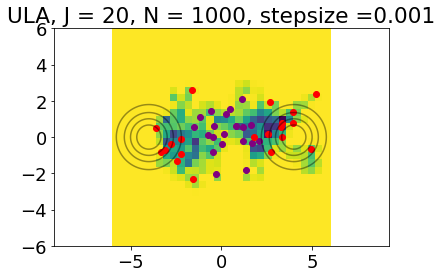

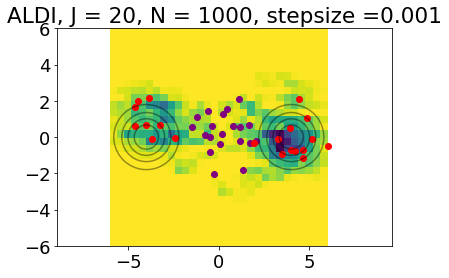

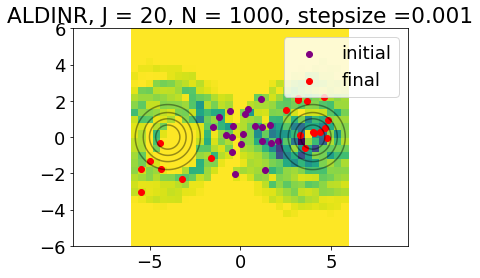


Experiment 1
ULA: 20.685091018676758 seconds
ALDI with gradient: 20.446983098983765 seconds
iter
0
lambda min
0.750788765345534
iter
500
lambda min
0.7867032499211449
ALDI NR: 20.204824209213257 seconds


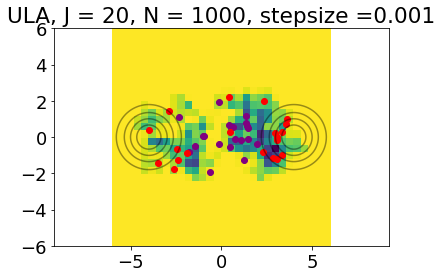

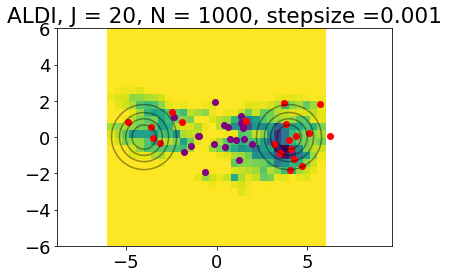

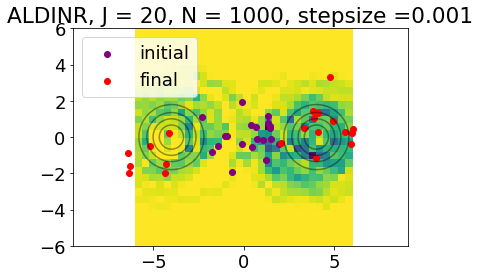


Experiment 1
ULA: 19.76429271697998 seconds
ALDI with gradient: 19.592783212661743 seconds
iter
0
lambda min
0.4170445629692328
iter
500
lambda min
0.9205109365915356
ALDI NR: 22.236448049545288 seconds


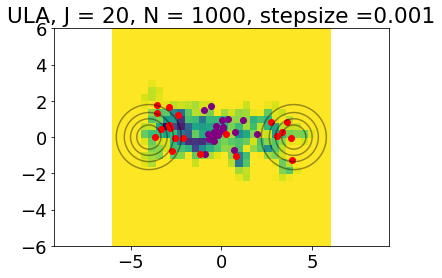

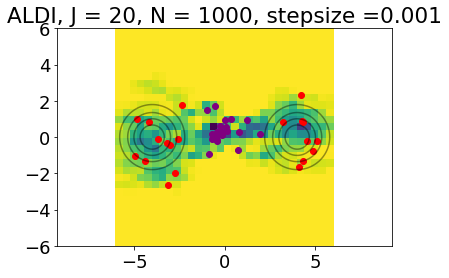

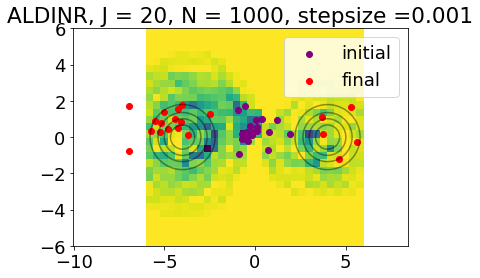

In [11]:
# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 1000 # number of iterations
tau = 1e-3 # step size

# parameters of our algorithm
const = 1.5 


N_exp = 3

for j in range(N_exp):
    
    print()
    print("Experiment 1")
    # resample initialization
    u0 = np.random.normal(0,1.0,(d,J)) 


    # ULA
    start_time = time.time()
    us_list_ULA = run_ULA_mog(I, N_sim, u0, tau)
    np.save('save_data/mog/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
            +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")

    # ALDI 
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient_mog(I, N_sim, u0, tau)
    np.save('save_data/mog/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                        +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")

    # NRALDI (our scheme)
    # eventually new parameters like stepsize

    tau_ALDINR = tau
    start_time = time.time()
    us_list_ALDINR = run_ALDINR_mog(I, N_sim, u0, tau_ALDINR, const) 
    np.save('save_data/mog/ALDINR_J_'\
                          +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)


    print(f"ALDI NR: {time.time()-start_time} seconds")
    
    # plot results
    
    val_min = min(( np.min(us_list_ULA), np.min(us_list_ALDI)))
    val_max = max(( np.max(us_list_ULA), np.max(us_list_ALDI)))

    name = nameof(us_list_ULA).lstrip('us_list')
    plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0],  color = "purple", label = 'initial')
    plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')


    name = nameof(us_list_ALDI).lstrip('us_list')
    plot_results(I, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red", label = 'final')

    name = nameof(us_list_ALDINR).lstrip('us_list')
    plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()




Experiment 1
ULA: 22.716217041015625 seconds
ALDI with gradient: 20.48321795463562 seconds
iter
0
lambda min
0.6851635650439183


/var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_25757/1336419766.py:169: ComplexWarning: Casting complex values to real discards the imaginary part
  us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


iter
500
lambda min
1.9392900309891776
ALDI NR: 22.766417980194092 seconds


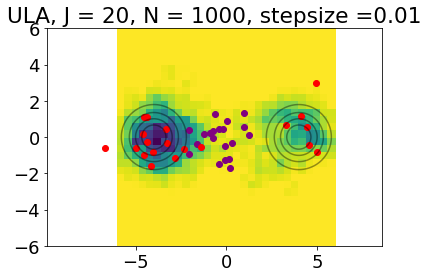

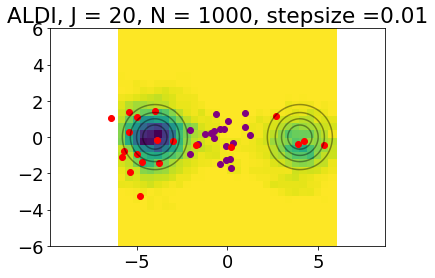

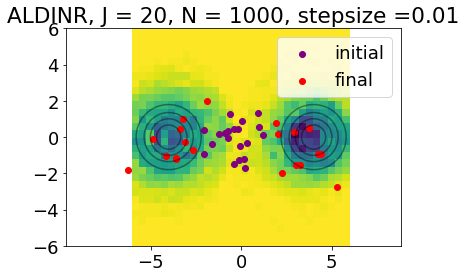


Experiment 1
ULA: 21.07468008995056 seconds
ALDI with gradient: 23.911244869232178 seconds
iter
0
lambda min
0.7827037210084677
iter
500
lambda min
1.8304340695115986
ALDI NR: 24.26614022254944 seconds


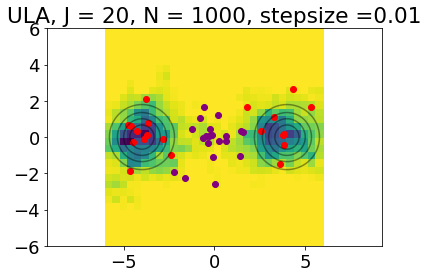

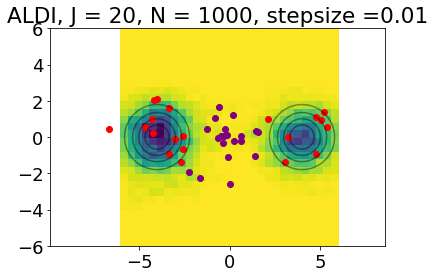

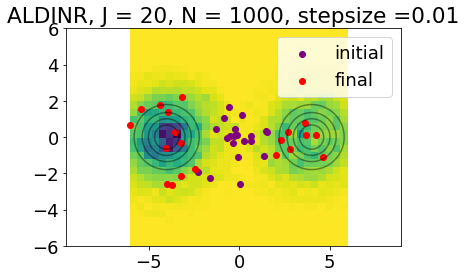


Experiment 1
ULA: 22.075413942337036 seconds
ALDI with gradient: 22.334394931793213 seconds
iter
0
lambda min
0.6732986531949126
iter
500
lambda min
1.8764392394226612
ALDI NR: 22.842699766159058 seconds


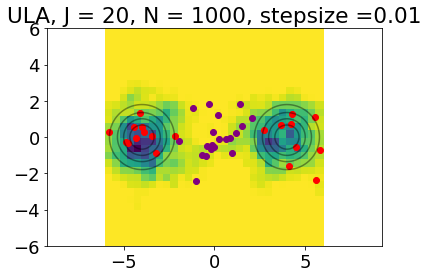

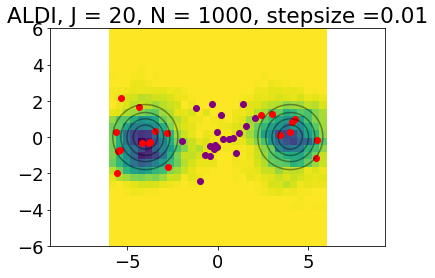

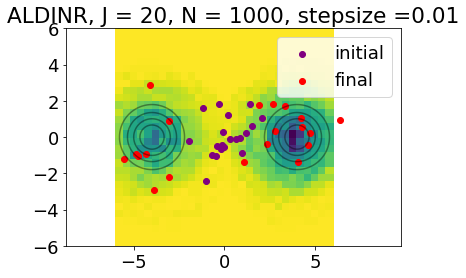

In [12]:


# try again but a big step size but the computation of gradient log I is not nice
# it can diverge (but it can work very well and very fast as well - quitte ou double)

# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 1000 # number of iterations
tau = 1e-2 # step size

# parameters of our algorithm
const = 1.5 


N_exp = 3

for j in range(N_exp):
    
    print()
    print("Experiment 1")
    # resample initialization
    u0 = np.random.normal(0,1.0,(d,J)) 


    # ULA
    start_time = time.time()
    us_list_ULA = run_ULA_mog(I, N_sim, u0, tau)
    np.save('save_data/mog/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
            +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")

    # ALDI 
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient_mog(I, N_sim, u0, tau)
    np.save('save_data/mog/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                        +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")

    # NRALDI (our scheme)
    # eventually new parameters like stepsize

    tau_ALDINR = tau
    start_time = time.time()
    us_list_ALDINR = run_ALDINR_mog(I, N_sim, u0, tau_ALDINR, const) 
    np.save('save_data/mog/ALDINR_J_'\
                          +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)


    print(f"ALDI NR: {time.time()-start_time} seconds")
    
    # plot results
    
    val_min = min(( np.min(us_list_ULA), np.min(us_list_ALDI)))
    val_max = max(( np.max(us_list_ULA), np.max(us_list_ALDI)))

    name = nameof(us_list_ULA).lstrip('us_list')
    plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0],  color = "purple", label = 'initial')
    plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')


    name = nameof(us_list_ALDI).lstrip('us_list')
    plot_results(I, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red", label = 'final')

    name = nameof(us_list_ALDINR).lstrip('us_list')
    plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()



## Plot some statistics for ALDINR

In [14]:


# target density
def bimodal_distribution(z, gap = 4, sigma1 = 1, sigma2 = 1):
    # Bimodal distribution probability density function
    mean1 = [-gap/2, 0]
    cov1 = [[sigma1, 0], [0, sigma1]]
    pdf1 = multivariate_normal(mean1, cov1).pdf(z)

    mean2 = [gap/2, 0]
    
    cov2 = [[sigma2, 0], [0, sigma2]]
    pdf2 = multivariate_normal(mean2, cov2).pdf(z)

    outcome= 0.5 * pdf1 + 0.5 * pdf2
    return outcome


# target potential
def potential(z):
    return -np.log(bimodal_distribution(z))

# target potential 2
I = lambda u: potential(np.stack((u[0],u[1]),axis=-1))


#not vectorized
def gradient_of_log_bimodal_distribution(z,  gap = 4, sigma1 = 1, sigma2 = 1):

    mean1 = np.asarray([-gap/2, 0])
    cov1 = [[sigma1, 0], [0, sigma1]]
    pdf1 = multivariate_normal(mean1, cov1).pdf(z) 
    

    mean2 = np.asarray([gap/2, 0])
    cov2 = [[sigma2, 0], [0, sigma2]]
    pdf2 = multivariate_normal(mean2, cov2).pdf(z)

    gradient= -  (1/(bimodal_distribution(z)))*(0.5*pdf1*np.matmul(np.linalg.inv(cov1),(z - mean1))\
                                                     +0.5*pdf2*np.matmul(np.linalg.inv(cov2),(z - mean2)))
    return gradient



######################################
#              MOG Case              #
######################################


def run_ULA_mog(potential, N_sim, u0, tau, grad_inference = gradient_of_log_bimodal_distribution):
    
    d, J  = u0.shape
    us_list_ULA = np.zeros((d, J, N_sim)) 
    us_list_ULA[:,:,0] = u0 
    
    for n in range(N_sim-1):    
        us = us_list_ULA[:,:,n]
        
        vs = np.zeros_like(us)
        for i in range(us.shape[1]):
            test = gradient_of_log_bimodal_distribution(us[:, i])
            vs[:, i] +=  gradient_of_log_bimodal_distribution(us[:, i])

        us_list_ULA[:,:,n+1] = us_list_ULA[:,:,n] + tau*vs \
            + np.sqrt(2*tau)*np.random.normal(0,1,(d,J))

    return us_list_ULA


# true_square_root = False: ALDI with nonsymmetric square root of C
def run_ALDI_with_gradient_mog(potential, N_sim, u0, tau, true_square_root = False, grad_inference = gradient_of_log_bimodal_distribution):
    
    d, J = u0.shape
    us_list_ALDI = np.zeros((d,J,N_sim))
    us_list_ALDI[:,:,0] = u0
    
    for n in range(N_sim-1):   
        
        us = us_list_ALDI[:,:,n]
        m_us = np.mean(us, axis=1)[:,np.newaxis]
        u_c = us - m_us 
        C = np.cov(us) * (J-1)/J 
        
        vs = np.zeros_like(us)
        for i in range(us.shape[1]):
            test = gradient_of_log_bimodal_distribution(us[:, i])#.reshape((2,1))
            vs[:, i] +=  gradient_of_log_bimodal_distribution(us[:, i])#.reshape((2,1))
        
        drift = + np.dot(C,vs) + (d+1)*1/J*(us-m_us) 
        
        if not true_square_root: 
            Csqrt = 1/np.sqrt(J) * u_c
            noise = np.random.normal(0,1,(J,J))
            diff = np.sqrt(2)*Csqrt@noise
        
        else: 
            sqrtC = scipy.linalg.sqrtm(C)
            noise = np.random.normal(0,1,(2,J))
            diff = np.sqrt(2) * np.dot(sqrtC,noise)
        
    
        us_list_ALDI[:,:,n+1] = us + tau * drift  + np.sqrt(tau) * diff

    return us_list_ALDI


# our scheme. with true square root of D, also without the corrective term of Nuesken
def run_ALDINR_mog(potential, N_sim, u0, tau, const, grad_inference = gradient_of_log_bimodal_distribution):

    d, J = u0.shape    
    us_list_ALDINR = np.zeros((d,J,N_sim))
    us_list_ALDINR[:,:,0] = u0
    
    # to track the convergence
    #preconditioners = np.ones((d, d, N_sim)) # product of (D_opt+J_opt)K^{-1}
    #preconditioners[:, :, 0] = np.cov(u0)*(J-1)/J
    
    for n in range(N_sim-1): 
        
        us = us_list_ALDINR[:,:,n] # shape (d, J)
        m_us = np.mean(us, axis=1)[:,np.newaxis] # shape (2, 1)
        C = np.cov(us)*(J-1)/J # shape (2,2)

        # compute sqrt C
        sqrtC = scipy.linalg.sqrtm(C)
        
        # compute D
        D_opt_tilde, v, lambda_min = construct_D_opt_tilde(C,d)
        if lambda_min> 500:
            print("ALDINR diverging")
            
        D_opt = construct_D_opt(C,d)

        if np.mod(n, 500) == 0:
            print("iter")
            print(n)
            print("lambda min")
            print(lambda_min)
            #print(C)
            
        # compute psis
        psis = construct_onb(d, v)
        
        # compute sqrt D
        sqrtD = scipy.linalg.sqrtm(D_opt) # we should be able to do something cheap here
        
        # compute J opt
        J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtC)
        
        T = J_opt +D_opt
        
        vs = np.zeros_like(us)
        for i in range(us.shape[1]):
            test = gradient_of_log_bimodal_distribution(us[:, i])#.reshape((2,1))
            vs[:, i] +=  gradient_of_log_bimodal_distribution(us[:, i])#.reshape((2,1))
        
        drift = + np.dot(T, vs) 
        noise = np.random.normal(0,1,(2,J))
        diff = np.sqrt(2) * np.dot(sqrtD,noise) 
        
        
        us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff 
        
        # keep record of some stats
        #preconditioners[:, :, n] = T
        
    return us_list_ALDINR #, preconditioners

In [28]:
# choose one experiment that works, ie the first one (small gap big step size)

d = 2

y = np.zeros(1)
val = 6
xmin = -val
xmax = val
ymin= -val
ymax= val


# potential function
sigma = 1
gap = 4

# potential function
nb_grid = 200

m1 = np.asarray([-1, 0]).reshape((2,1))
m2 = np.asarray([1, 0]).reshape((2,1))

I1 = lambda u: 0.5/(sigma**2)*((u[0] - gap/2)**2 + u[1]**2) # TODO: recoder ça bien
I2 = lambda u: 0.5/(sigma**2)*((u[0] + gap/2)**2 + u[1]**2)

I = lambda u: - np.log(np.exp(-I1(u)) + np.exp(-I2(u)))


# plot posterior

u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U = np.meshgrid(u0s,u1s)
#U = np.stack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = np.exp(-I1(U)) + np.exp(-I2(U))

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z # check the computation
#dens = unnorm_dens

marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)



Experiment 5
(2, 20)
ULA: 19.833900928497314 seconds
ALDI with gradient: 19.95386505126953 seconds
iter
0
lambda min
1.625970155853976


/var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_25757/1689426094.py:160: ComplexWarning: Casting complex values to real discards the imaginary part
  us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


iter
500
lambda min
0.812845312163441
ALDI NR: 20.178242921829224 seconds


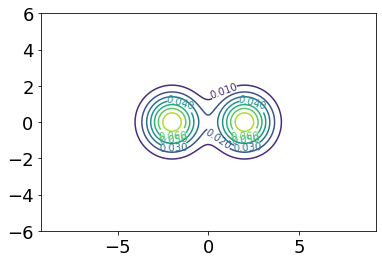

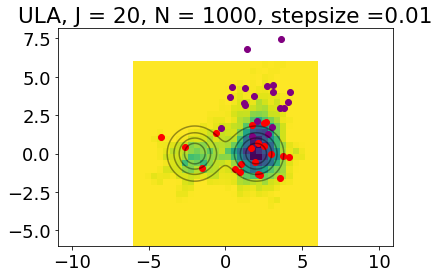

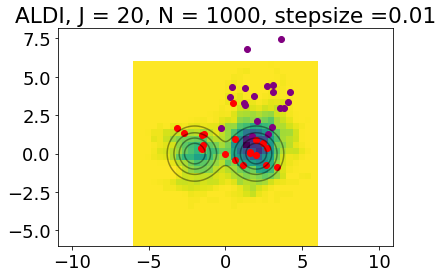

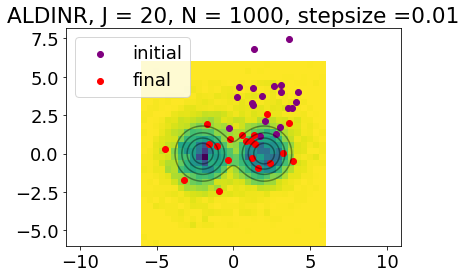


Experiment 5
(2, 20)
ULA: 20.49060297012329 seconds
ALDI with gradient: 20.175071954727173 seconds
iter
0
lambda min
0.8835261163458425
iter
500
lambda min
0.5999397221955671
ALDI NR: 20.636560201644897 seconds


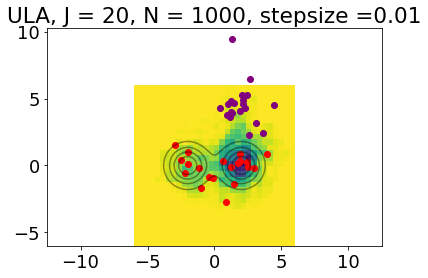

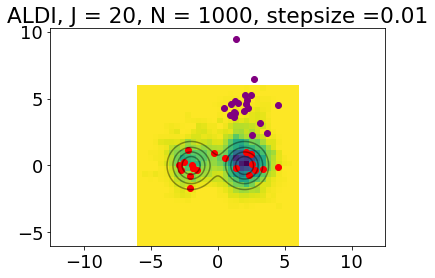

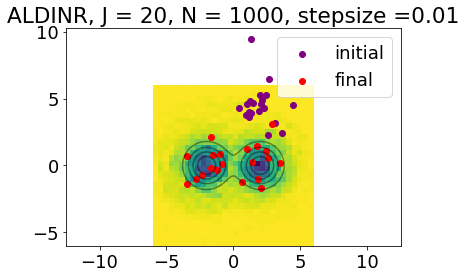


Experiment 5
(2, 20)
ULA: 19.720923900604248 seconds
ALDI with gradient: 19.75063920021057 seconds
iter
0
lambda min
0.6565299406884456
iter
500
lambda min
1.3661205369465328
ALDI NR: 20.266290187835693 seconds


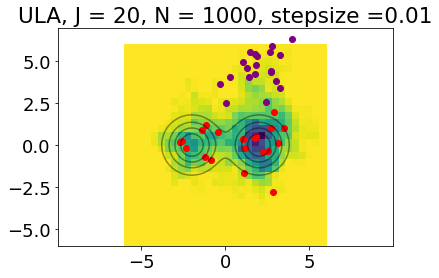

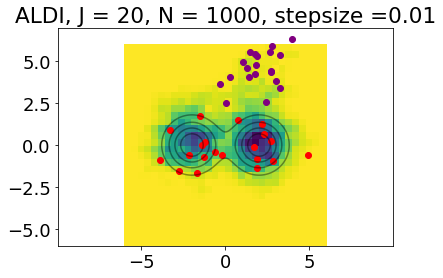

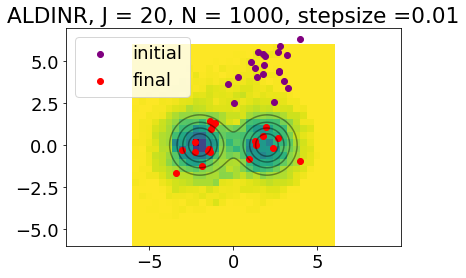


Experiment 5
(2, 20)
ULA: 20.98775315284729 seconds
ALDI with gradient: 20.801932096481323 seconds
iter
0
lambda min
1.5523184099018803
iter
500
lambda min
0.658690365439613
ALDI NR: 21.01557493209839 seconds


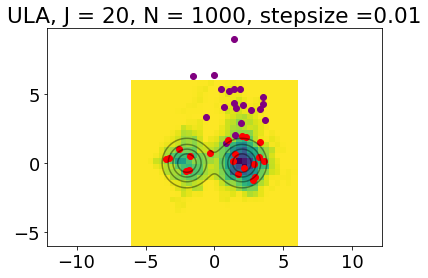

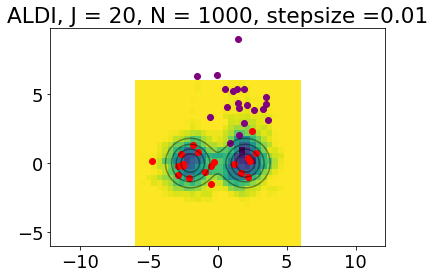

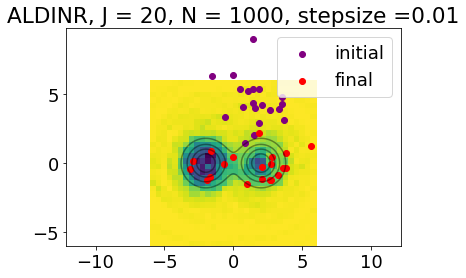


Experiment 5
(2, 20)
ULA: 20.340561866760254 seconds
ALDI with gradient: 20.042904138565063 seconds
iter
0
lambda min
0.9208160567606197
iter
500
lambda min
1.3384247544436108
ALDI NR: 20.554004192352295 seconds


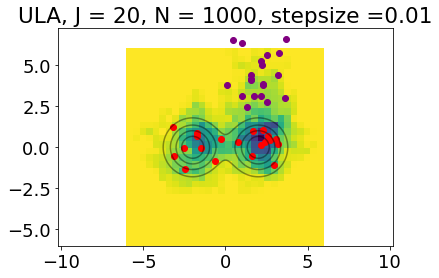

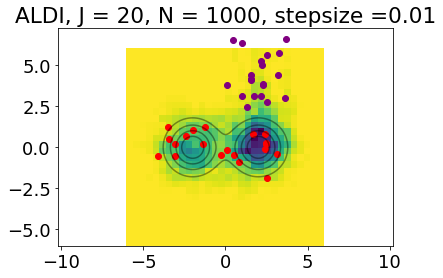

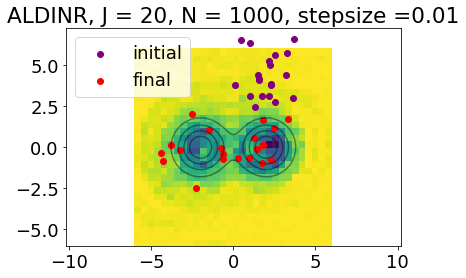


Experiment 5
(2, 20)
ULA: 20.640774965286255 seconds
ALDI with gradient: 20.427011966705322 seconds
iter
0
lambda min
0.6622829773138759
iter
500
lambda min
0.865494003118132
ALDI NR: 20.688735008239746 seconds


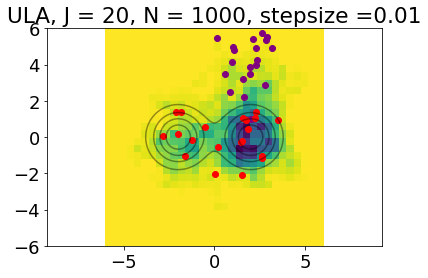

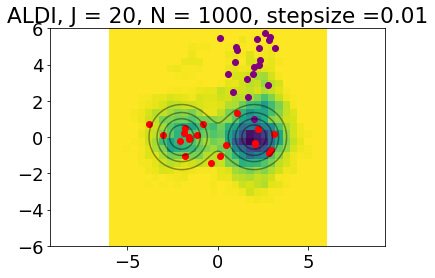

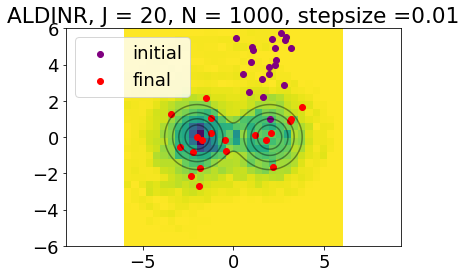


Experiment 5
(2, 20)
ULA: 20.079121112823486 seconds
ALDI with gradient: 19.852121829986572 seconds
iter
0
lambda min
0.615216693124689
iter
500
lambda min
1.3207128019716845
ALDI NR: 20.3802490234375 seconds


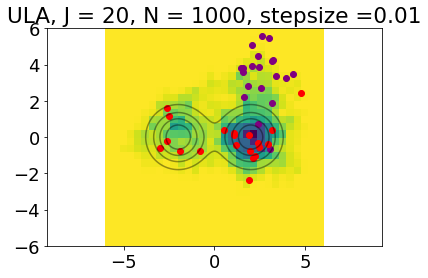

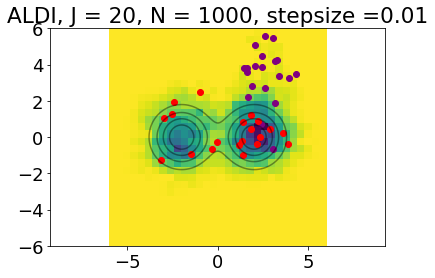

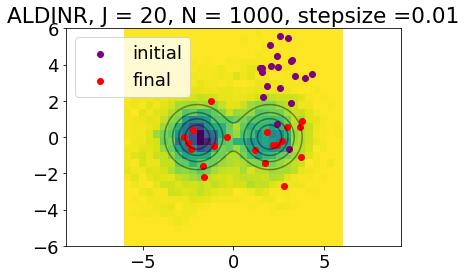


Experiment 5
(2, 20)
ULA: 20.120571851730347 seconds
ALDI with gradient: 20.04173731803894 seconds
iter
0
lambda min
0.8720905276519115
iter
500
lambda min
0.7693755610828524
ALDI NR: 20.798020124435425 seconds


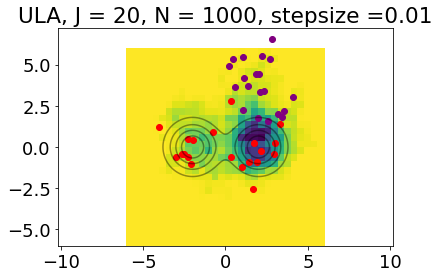

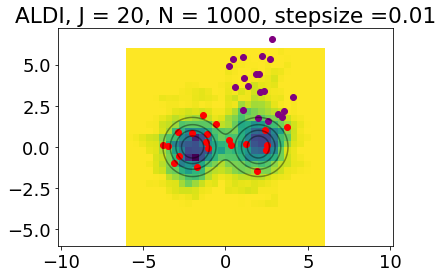

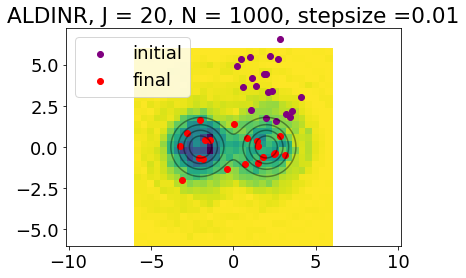


Experiment 5
(2, 20)
ULA: 20.64174175262451 seconds
ALDI with gradient: 20.002352952957153 seconds
iter
0
lambda min
0.8380460630953851
iter
500
lambda min
0.8198275515814882
ALDI NR: 21.73431396484375 seconds


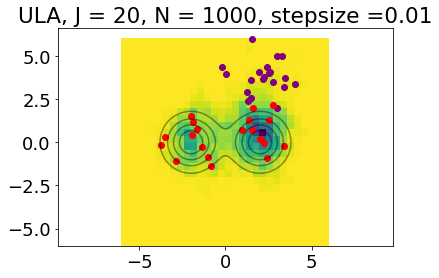

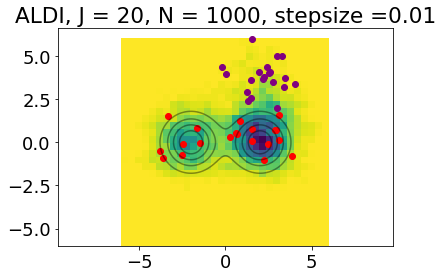

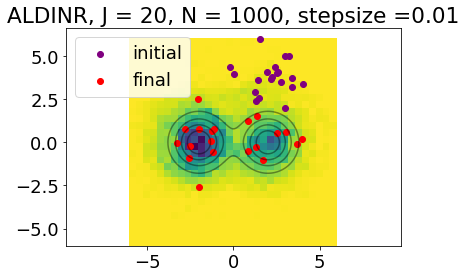


Experiment 5
(2, 20)
ULA: 21.022032976150513 seconds
ALDI with gradient: 20.560479164123535 seconds
iter
0
lambda min
0.539704112526475
iter
500
lambda min
1.0853229233821369
ALDI NR: 20.629441022872925 seconds


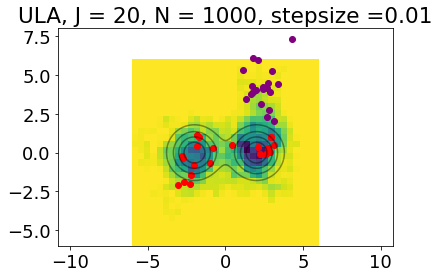

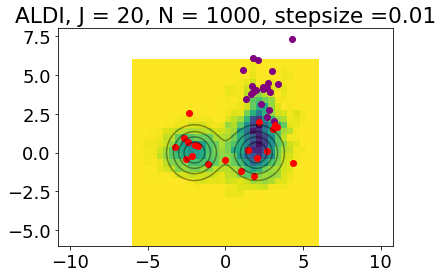

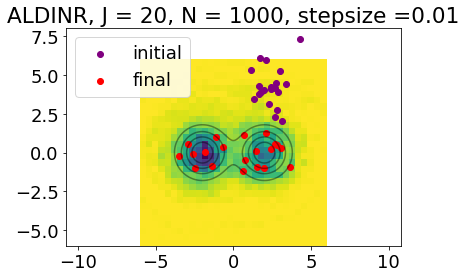


Experiment 5
(2, 20)
ULA: 20.2413330078125 seconds
ALDI with gradient: 20.107213020324707 seconds
iter
0
lambda min
0.9077806964138628
iter
500
lambda min
2.4209696303423427
ALDI NR: 20.366406202316284 seconds


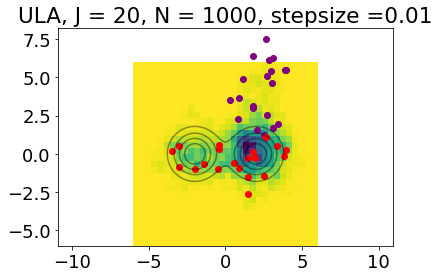

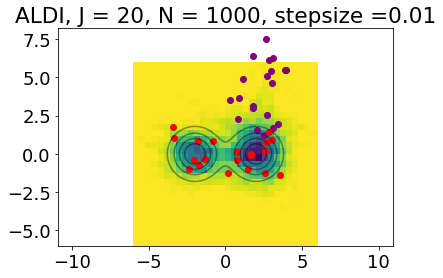

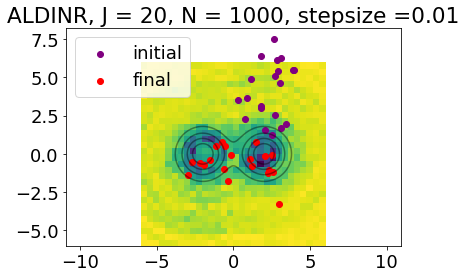


Experiment 5
(2, 20)
ULA: 20.124747037887573 seconds
ALDI with gradient: 20.133881092071533 seconds
iter
0
lambda min
0.8530496826155745
iter
500
lambda min
0.6580033599147048
ALDI NR: 20.55882692337036 seconds


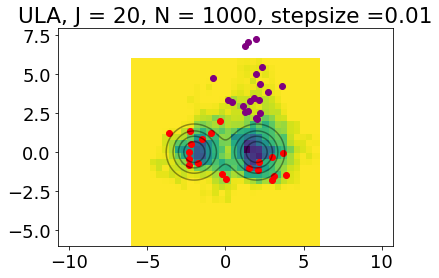

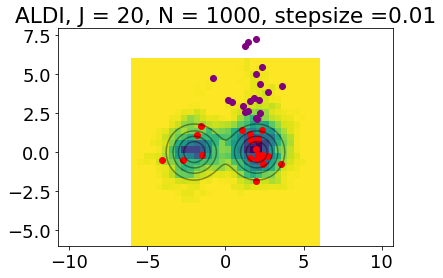

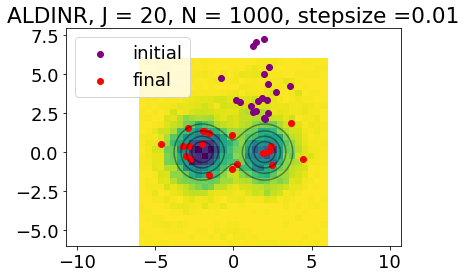


Experiment 5
(2, 20)
ULA: 20.090306043624878 seconds
ALDI with gradient: 19.962770223617554 seconds
iter
0
lambda min
0.6563753559890155
iter
500
lambda min
1.1096658306515774
ALDI NR: 20.614941835403442 seconds


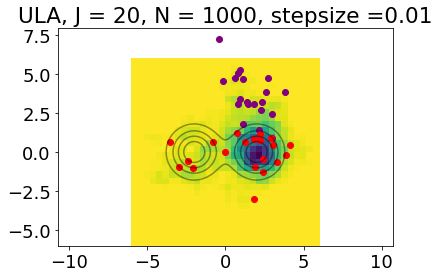

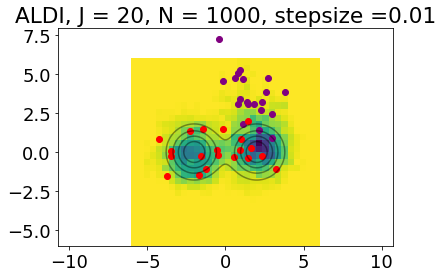

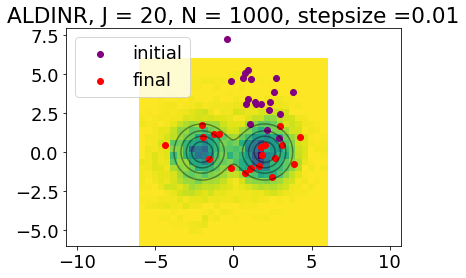


Experiment 5
(2, 20)
ULA: 20.594829082489014 seconds
ALDI with gradient: 20.281458139419556 seconds
iter
0
lambda min
0.9586907207373675
iter
500
lambda min
0.44439806474702875
ALDI NR: 20.76292395591736 seconds


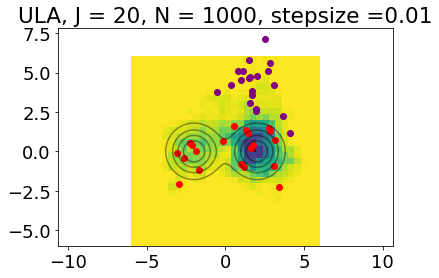

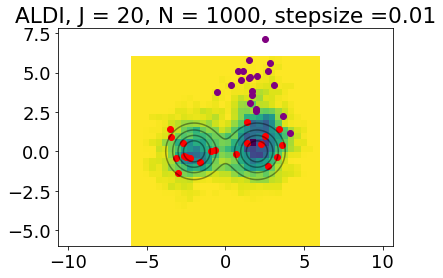

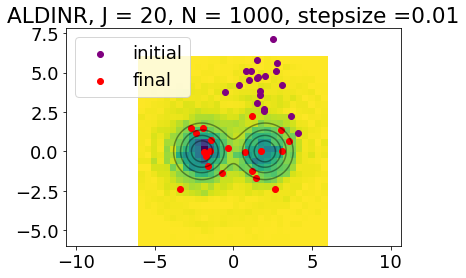


Experiment 5
(2, 20)
ULA: 20.296290159225464 seconds
ALDI with gradient: 19.853283882141113 seconds
iter
0
lambda min
0.7485524423244725
iter
500
lambda min
0.5853538062193737
ALDI NR: 20.567380905151367 seconds


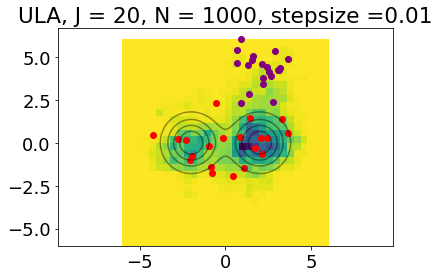

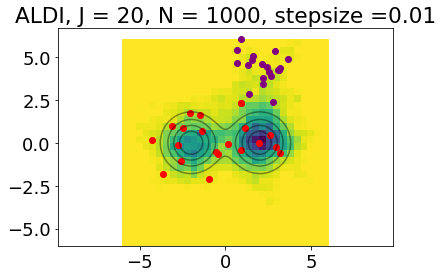

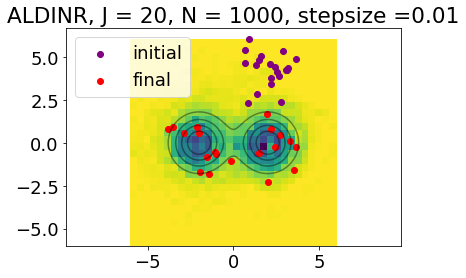


Experiment 5
(2, 20)
ULA: 20.446266174316406 seconds
ALDI with gradient: 20.238647937774658 seconds
iter
0
lambda min
0.6727352625620173
iter
500
lambda min
0.4321464161644324
ALDI NR: 20.85326600074768 seconds


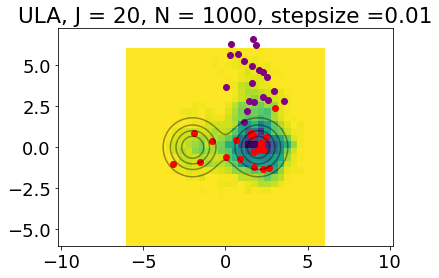

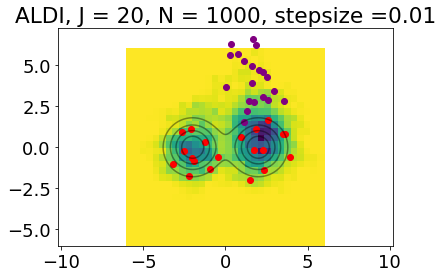

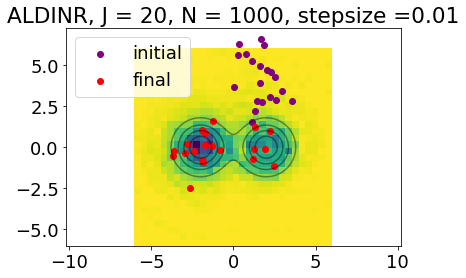


Experiment 5
(2, 20)
ULA: 20.039642810821533 seconds
ALDI with gradient: 19.966789960861206 seconds
iter
0
lambda min
0.9732284604878436
iter
500
lambda min
0.8798576357160317
ALDI NR: 20.79056406021118 seconds


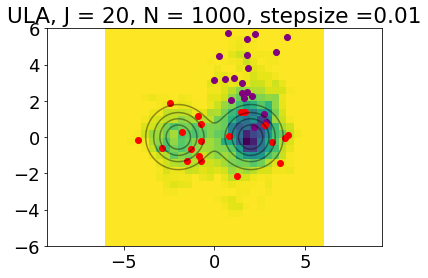

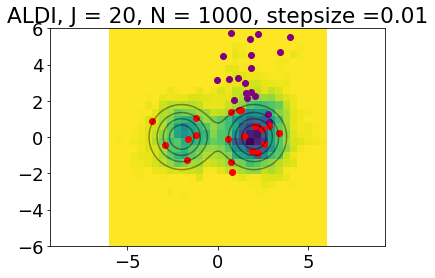

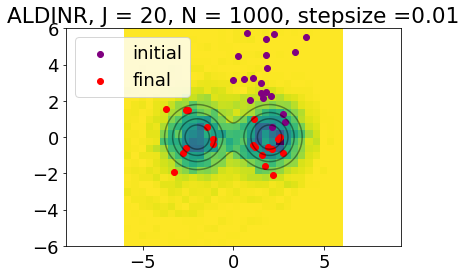


Experiment 5
(2, 20)
ULA: 20.612226009368896 seconds
ALDI with gradient: 20.430065870285034 seconds
iter
0
lambda min
0.9202334102526462
iter
500
lambda min
1.1174543644418713
ALDI NR: 21.147905111312866 seconds


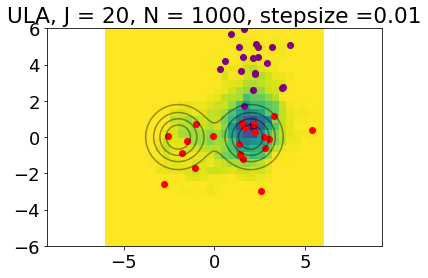

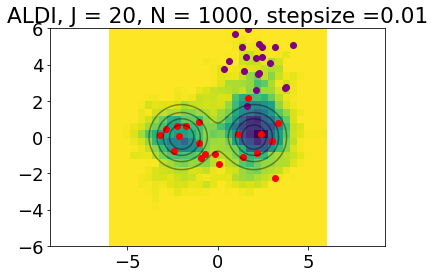

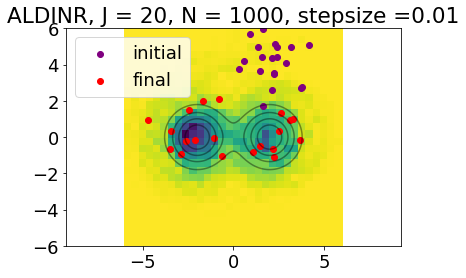


Experiment 5
(2, 20)
ULA: 19.731725931167603 seconds
ALDI with gradient: 19.857813835144043 seconds
iter
0
lambda min
1.0740549231876546
iter
500
lambda min
1.361017586081985
ALDI NR: 20.746950149536133 seconds


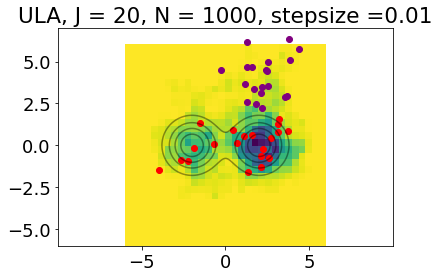

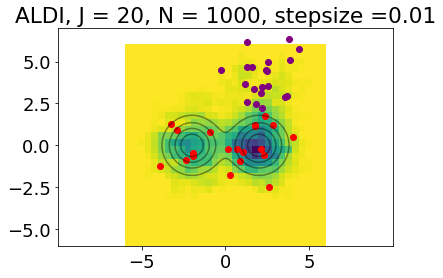

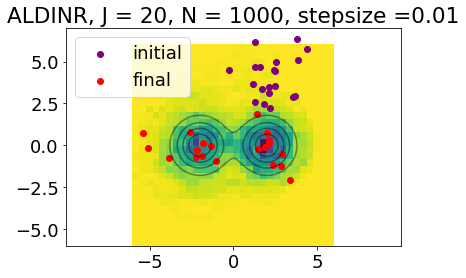


Experiment 5
(2, 20)
ULA: 19.821893215179443 seconds
ALDI with gradient: 20.19911289215088 seconds
iter
0
lambda min
0.7626525021987031
iter
500
lambda min
0.6487999246011059
ALDI NR: 21.27848792076111 seconds


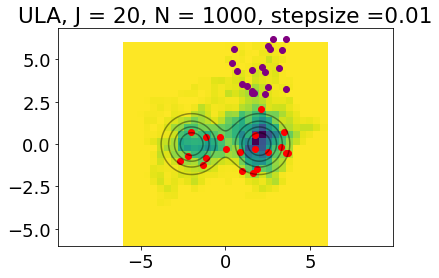

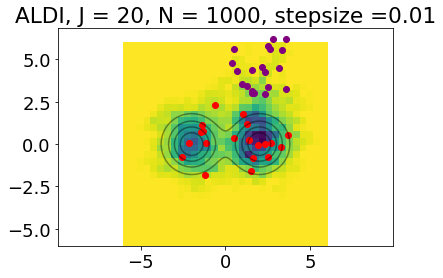

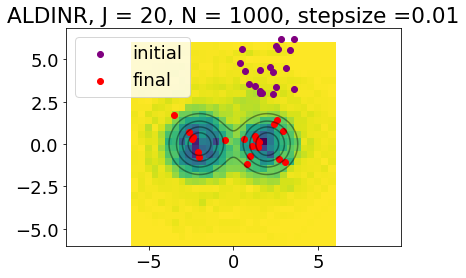


Experiment 5
(2, 20)
ULA: 20.140102863311768 seconds
ALDI with gradient: 19.966211795806885 seconds
iter
0
lambda min
0.6420053196661382
iter
500
lambda min
2.9205214426486266
ALDI NR: 20.755826950073242 seconds


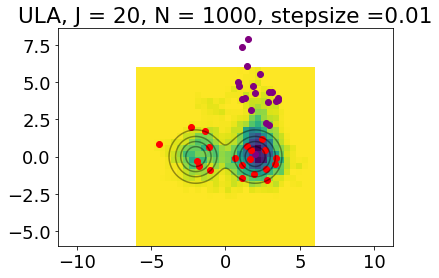

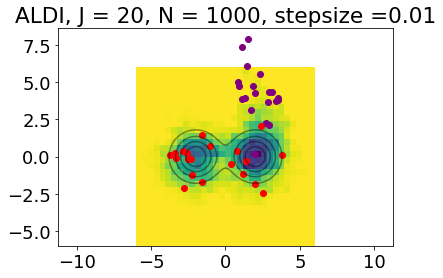

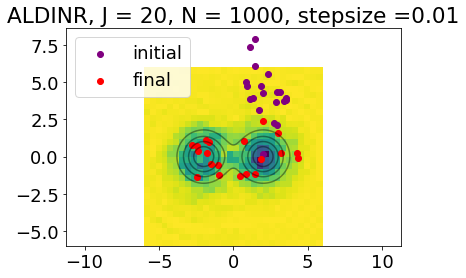


Experiment 5
(2, 20)
ULA: 19.722193956375122 seconds
ALDI with gradient: 20.688329935073853 seconds
iter
0
lambda min
0.6371450568990357
iter
500
lambda min
1.3613608634339682
ALDI NR: 21.02953028678894 seconds


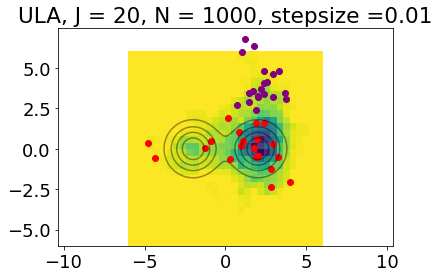

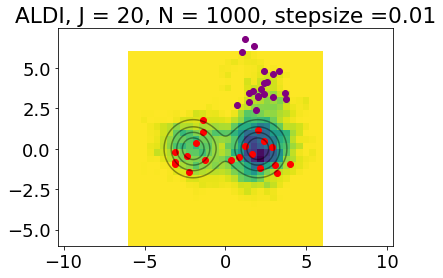

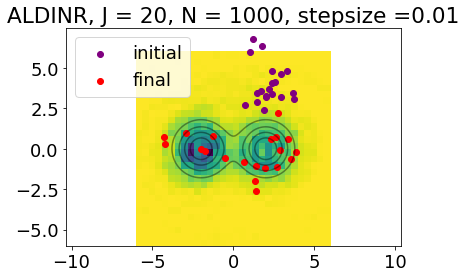


Experiment 5
(2, 20)
ULA: 20.234596967697144 seconds
ALDI with gradient: 20.176679134368896 seconds
iter
0
lambda min
0.9013365248934533
iter
500
lambda min
1.3502495470477809
ALDI NR: 20.769090175628662 seconds


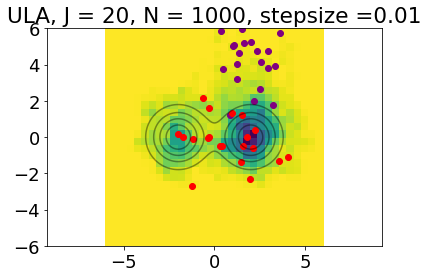

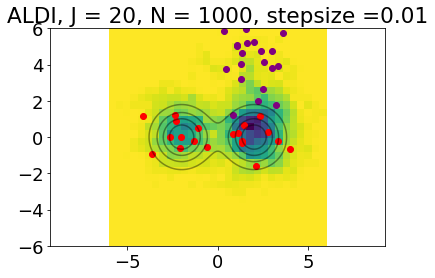

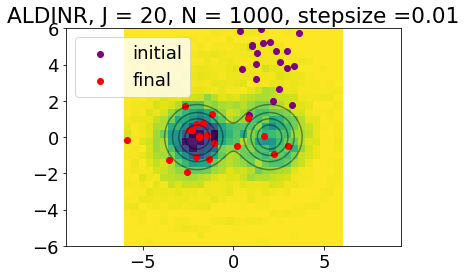


Experiment 5
(2, 20)
ULA: 19.784356117248535 seconds
ALDI with gradient: 20.125082969665527 seconds
iter
0
lambda min
0.7225585156016057
iter
500
lambda min
1.468264810197837
ALDI NR: 20.718407154083252 seconds


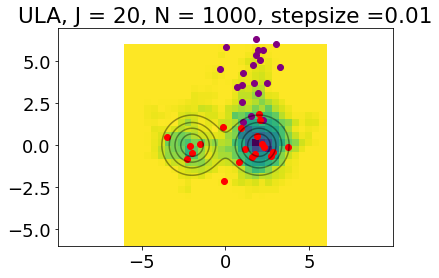

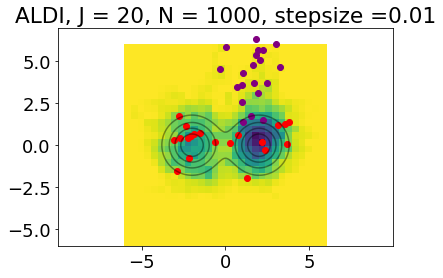

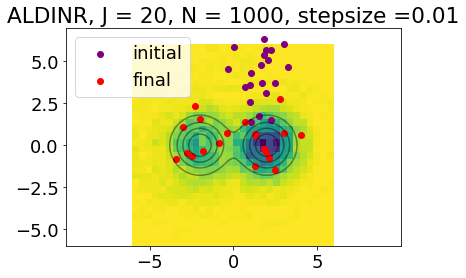


Experiment 5
(2, 20)
ULA: 19.676060914993286 seconds
ALDI with gradient: 19.607701301574707 seconds
iter
0
lambda min
0.4018839713906446
iter
500
lambda min
0.921638016237215
ALDI NR: 21.025200128555298 seconds


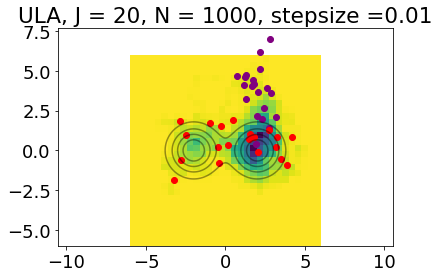

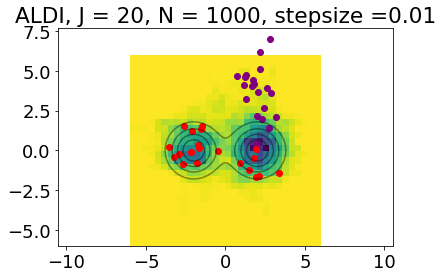

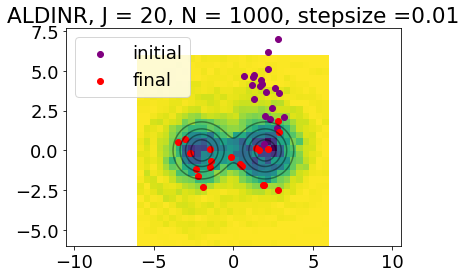


Experiment 5
(2, 20)
ULA: 20.39191508293152 seconds
ALDI with gradient: 20.037271976470947 seconds
iter
0
lambda min
0.7093027486461381
iter
500
lambda min
1.093669589750174
ALDI NR: 20.66961097717285 seconds


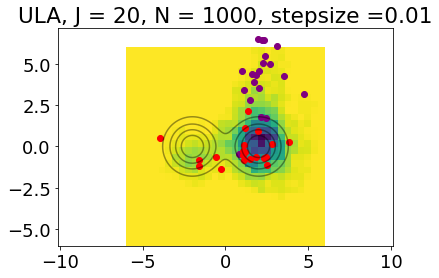

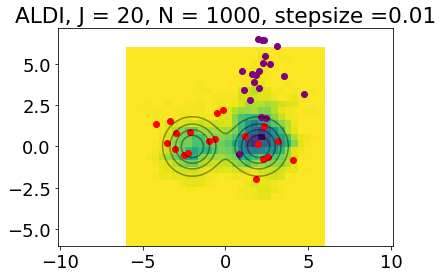

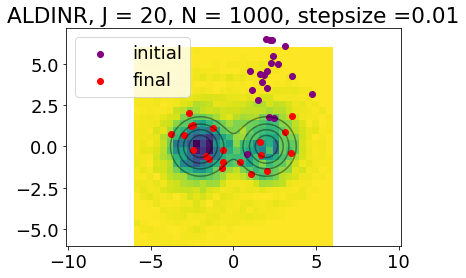


Experiment 5
(2, 20)
ULA: 19.900856971740723 seconds
ALDI with gradient: 20.767287015914917 seconds
iter
0
lambda min
0.8301459912642666
iter
500
lambda min
0.9706285998957876
ALDI NR: 21.02784299850464 seconds


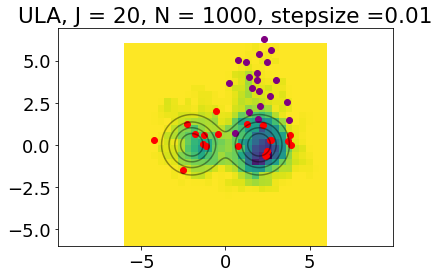

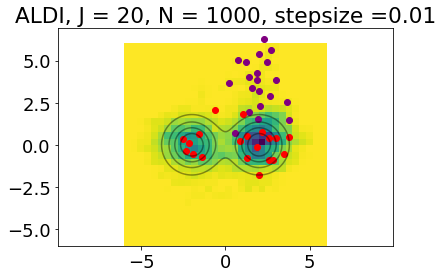

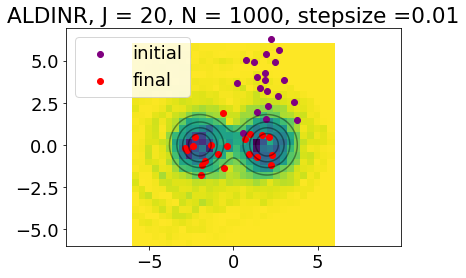


Experiment 5
(2, 20)
ULA: 20.229012966156006 seconds
ALDI with gradient: 19.988444089889526 seconds
iter
0
lambda min
0.778609193609453
iter
500
lambda min
1.6163932867523942
ALDI NR: 20.992247819900513 seconds


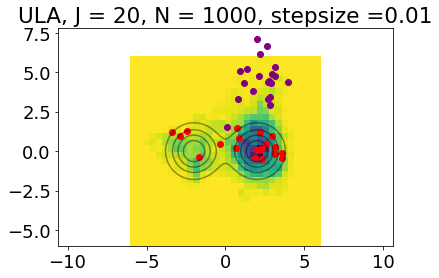

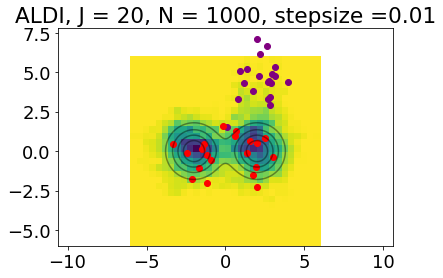

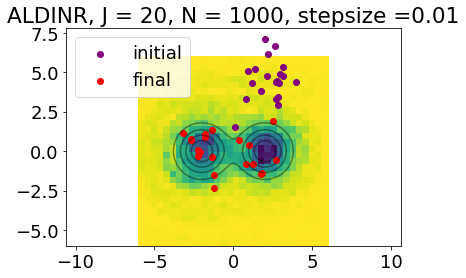


Experiment 5
(2, 20)
ULA: 19.75399112701416 seconds
ALDI with gradient: 20.674143075942993 seconds
iter
0
lambda min
0.5934689077082905
iter
500
lambda min
1.0588357643895605
ALDI NR: 20.50562882423401 seconds


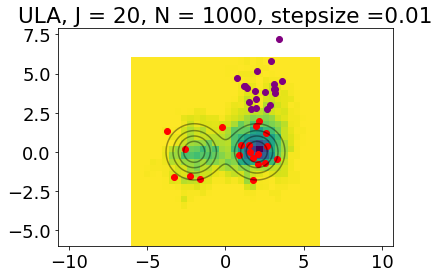

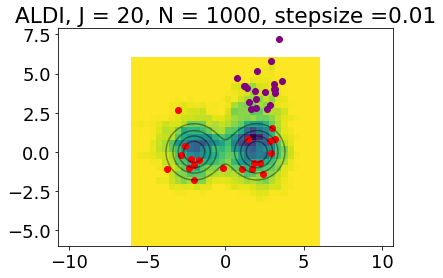

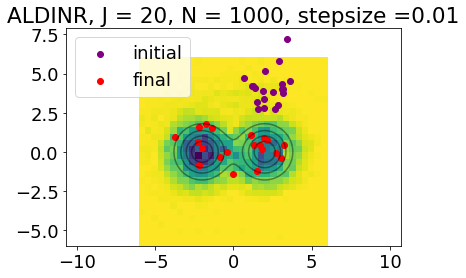


Experiment 5
(2, 20)
ULA: 20.187623023986816 seconds
ALDI with gradient: 20.141112089157104 seconds
iter
0
lambda min
0.9161354925278444
iter
500
lambda min
1.0219782801005723
ALDI NR: 20.4912588596344 seconds


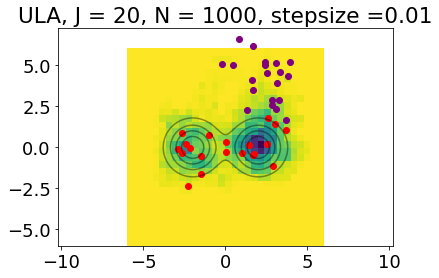

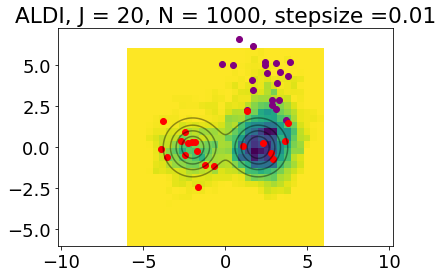

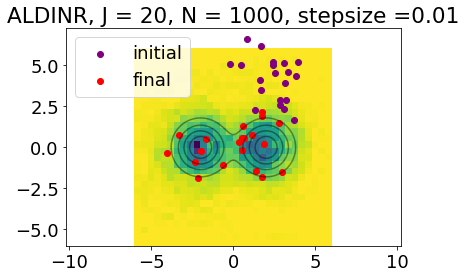


Experiment 5
(2, 20)
ULA: 20.433287143707275 seconds
ALDI with gradient: 21.354408979415894 seconds
iter
0
lambda min
1.3656069727645228
iter
500
lambda min
1.0010700733656583
ALDI NR: 20.62969183921814 seconds


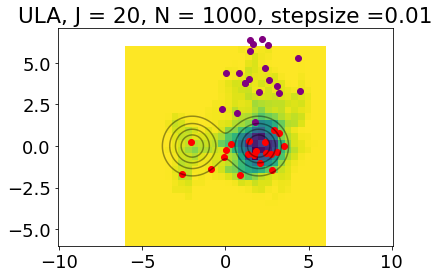

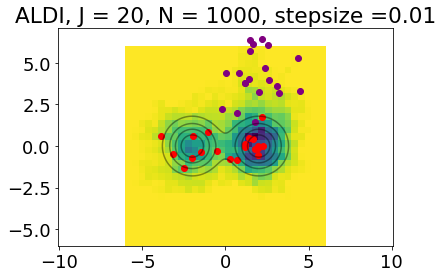

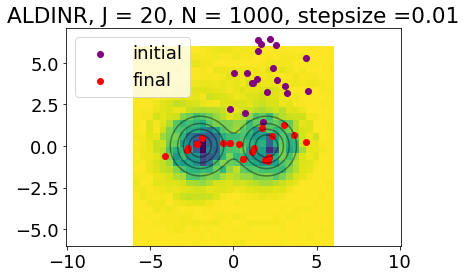


Experiment 5
(2, 20)
ULA: 20.105713844299316 seconds
ALDI with gradient: 20.12485694885254 seconds
iter
0
lambda min
0.9212960835093114
iter
500
lambda min
1.7245210453139743
ALDI NR: 20.4465012550354 seconds


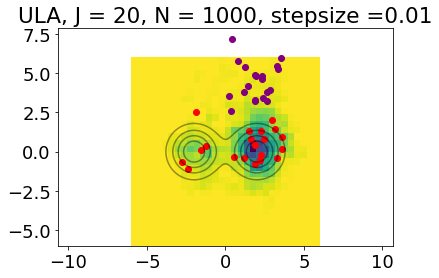

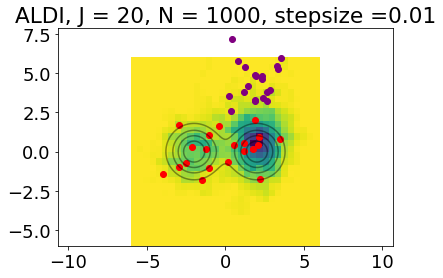

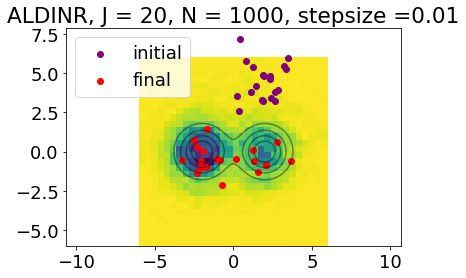


Experiment 5
(2, 20)
ULA: 20.02603816986084 seconds
ALDI with gradient: 20.29514479637146 seconds
iter
0
lambda min
0.4848031459682125
iter
500
lambda min
0.6153522888241623
ALDI NR: 20.38679599761963 seconds


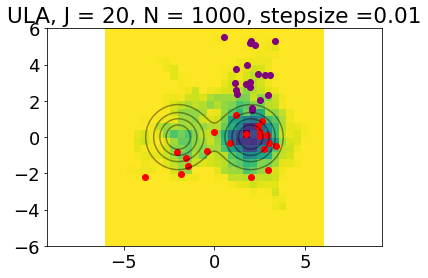

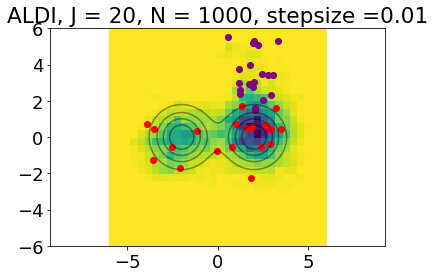

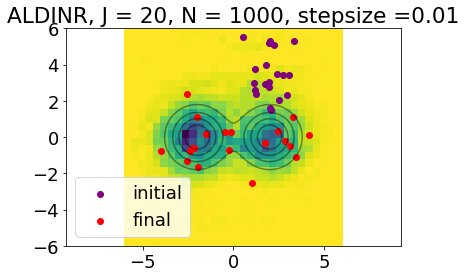


Experiment 5
(2, 20)
ULA: 20.750918865203857 seconds
ALDI with gradient: 20.398459911346436 seconds
iter
0
lambda min
0.6973453096969755
iter
500
lambda min
0.9346923771449354
ALDI NR: 20.473065853118896 seconds


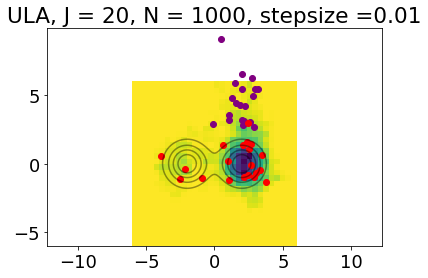

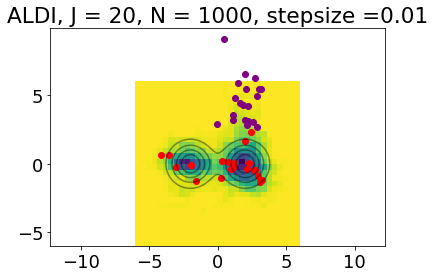

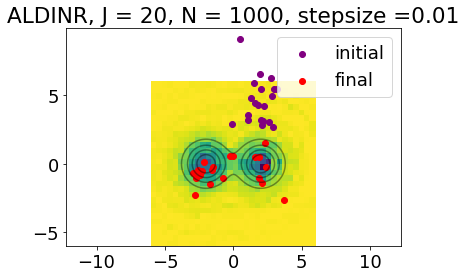


Experiment 5
(2, 20)
ULA: 20.055952310562134 seconds
ALDI with gradient: 20.950900077819824 seconds
iter
0
lambda min
0.3674313336957957
iter
500
lambda min
2.206285922025773
ALDI NR: 20.905023097991943 seconds


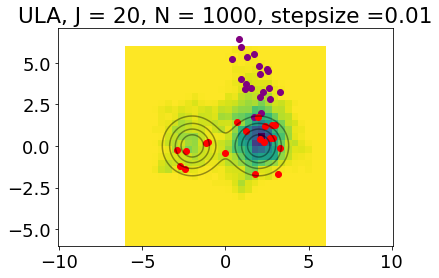

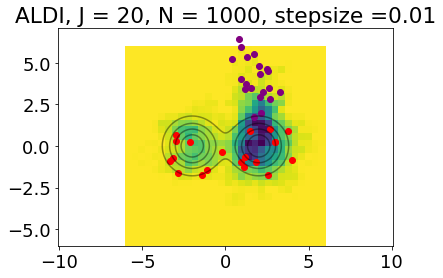

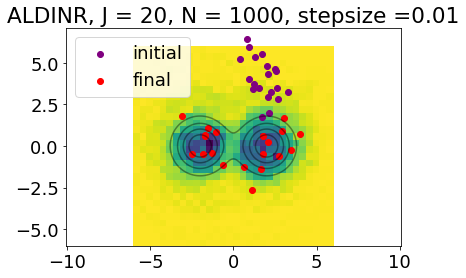


Experiment 5
(2, 20)
ULA: 20.240131855010986 seconds
ALDI with gradient: 21.915382862091064 seconds
iter
0
lambda min
0.6774743882222191
iter
500
lambda min
0.3700239448075153
ALDI NR: 22.137727975845337 seconds


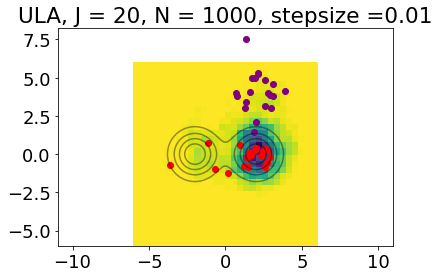

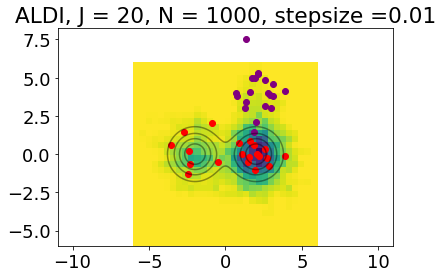

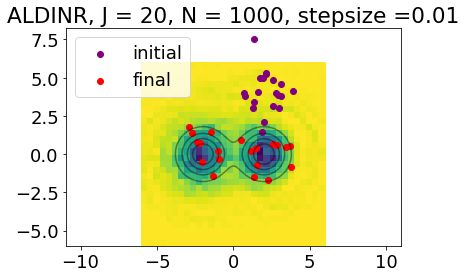


Experiment 5
(2, 20)
ULA: 22.509544849395752 seconds
ALDI with gradient: 26.049365043640137 seconds
iter
0
lambda min
0.8158743193904374
iter
500
lambda min
0.8266103699272901
ALDI NR: 23.703146934509277 seconds


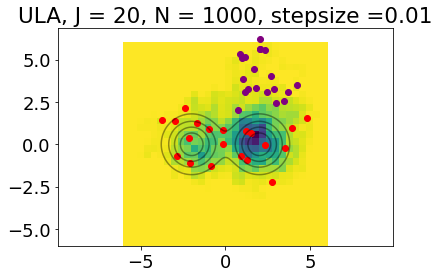

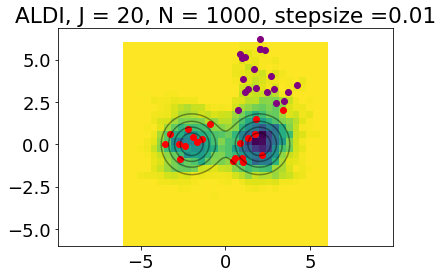

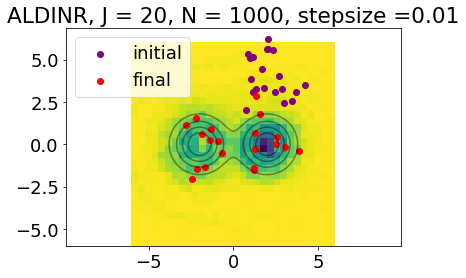


Experiment 5
(2, 20)
ULA: 23.6671199798584 seconds
ALDI with gradient: 22.209232807159424 seconds
iter
0
lambda min
0.9078098658056445
iter
500
lambda min
1.0739279288568429
ALDI NR: 24.616949796676636 seconds


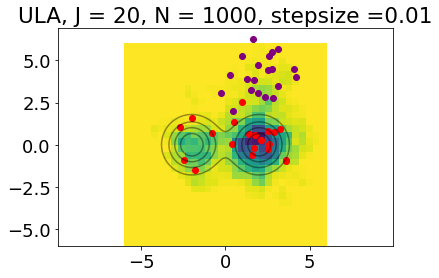

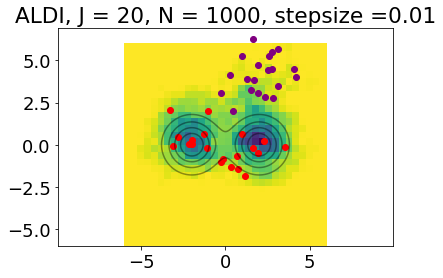

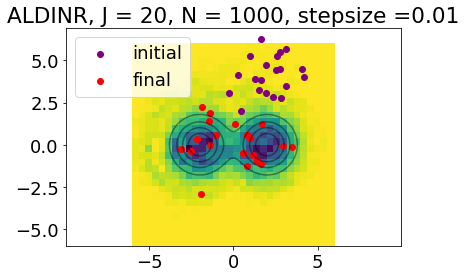


Experiment 5
(2, 20)
ULA: 23.21138095855713 seconds
ALDI with gradient: 24.616910219192505 seconds
iter
0
lambda min
0.9261345382544133
iter
500
lambda min
0.7405995332316875
ALDI NR: 22.040106296539307 seconds


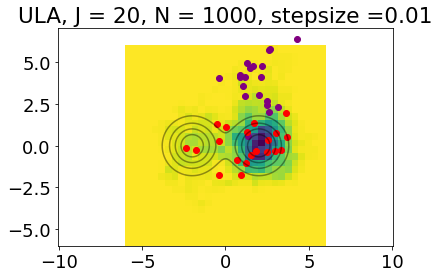

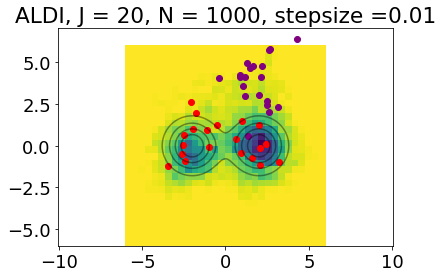

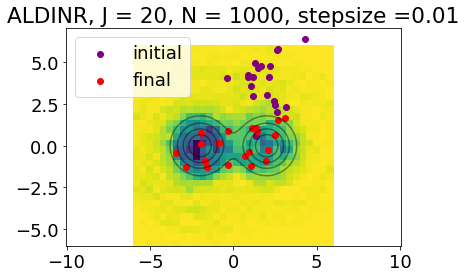


Experiment 5
(2, 20)
ULA: 23.888485193252563 seconds
ALDI with gradient: 24.052368879318237 seconds
iter
0
lambda min
1.190934420726951
iter
500
lambda min
0.6857600379767202
ALDI NR: 24.61876916885376 seconds


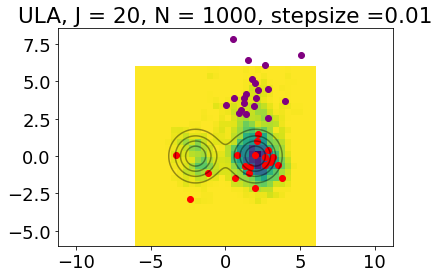

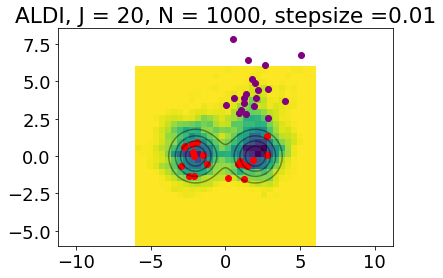

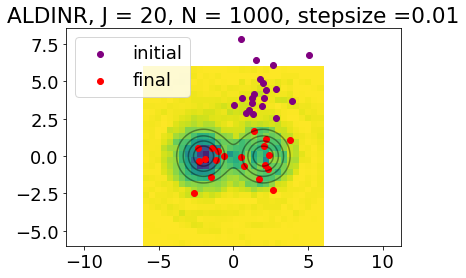


Experiment 5
(2, 20)
ULA: 23.376465320587158 seconds
ALDI with gradient: 22.454140186309814 seconds
iter
0
lambda min
0.7115064179743817
iter
500
lambda min
1.2159006003187998
ALDI NR: 23.036941051483154 seconds


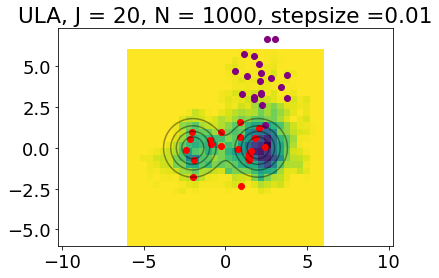

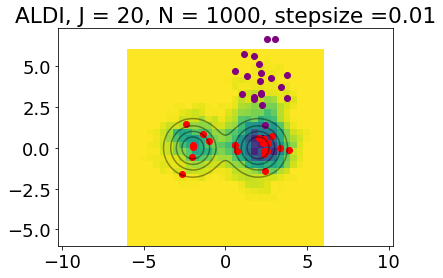

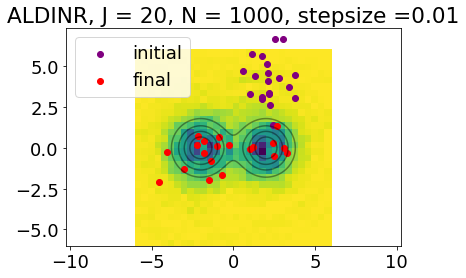


Experiment 5
(2, 20)
ULA: 24.999022006988525 seconds
ALDI with gradient: 24.57471799850464 seconds
iter
0
lambda min
0.2839096745728831
iter
500
lambda min
0.7537317173380159
ALDI NR: 23.4945170879364 seconds


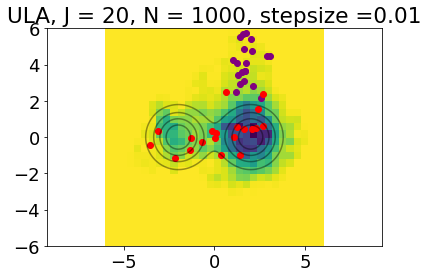

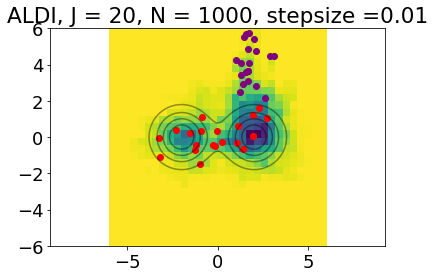

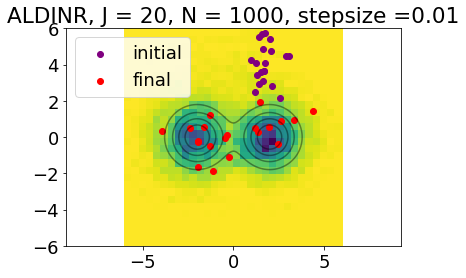


Experiment 5
(2, 20)
ULA: 24.071342706680298 seconds
ALDI with gradient: 24.00438690185547 seconds
iter
0
lambda min
1.3689144403166875
iter
500
lambda min
1.0891893988500494
ALDI NR: 23.530609130859375 seconds


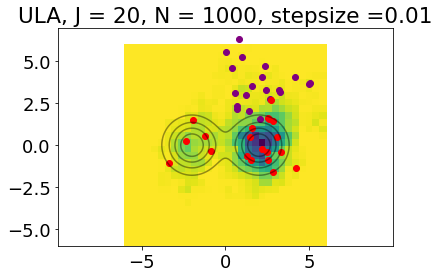

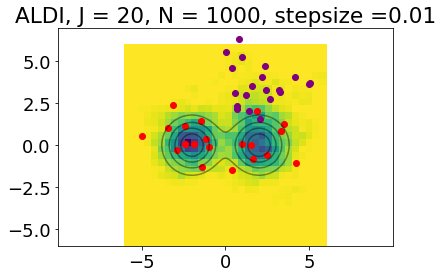

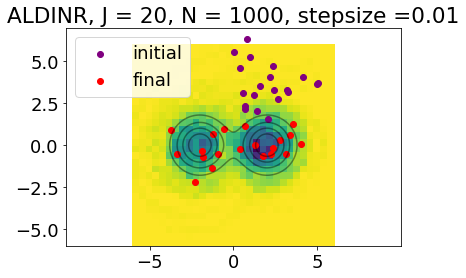


Experiment 5
(2, 20)
ULA: 21.164930820465088 seconds
ALDI with gradient: 20.015900135040283 seconds
iter
0
lambda min
0.46027240355129084
iter
500
lambda min
1.0483171058424614
ALDI NR: 20.178578853607178 seconds


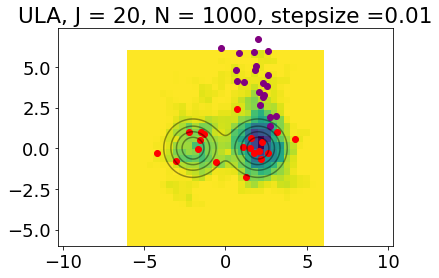

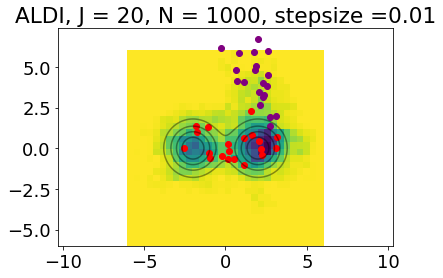

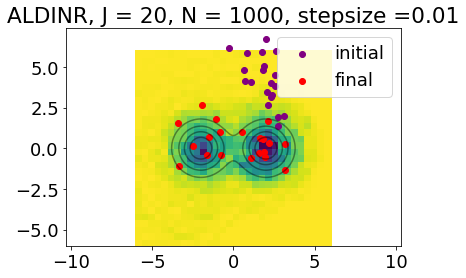


Experiment 5
(2, 20)
ULA: 22.444144010543823 seconds
ALDI with gradient: 22.568097829818726 seconds
iter
0
lambda min
0.6334058942461112
iter
500
lambda min
0.9245606924530826
ALDI NR: 23.793782949447632 seconds


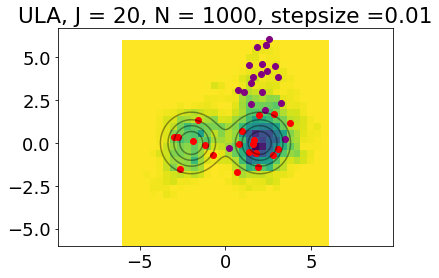

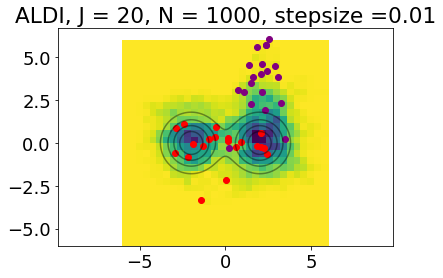

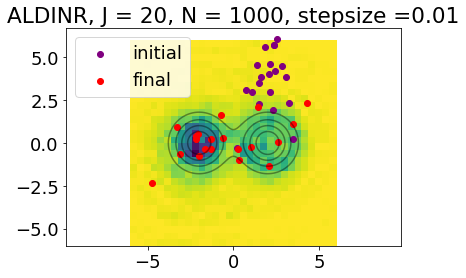


Experiment 5
(2, 20)
ULA: 23.411250829696655 seconds
ALDI with gradient: 22.937888145446777 seconds
iter
0
lambda min
0.8562540572145956
iter
500
lambda min
1.2549453015471357
ALDI NR: 24.266419172286987 seconds


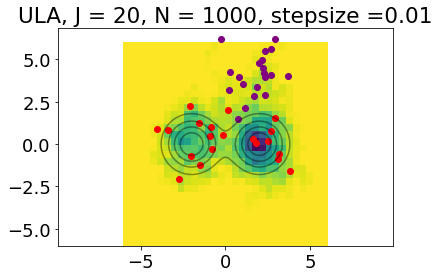

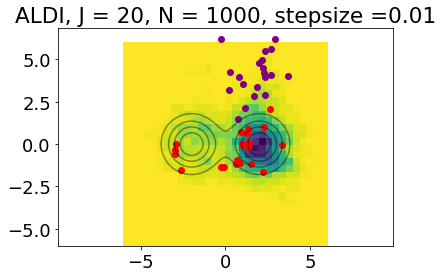

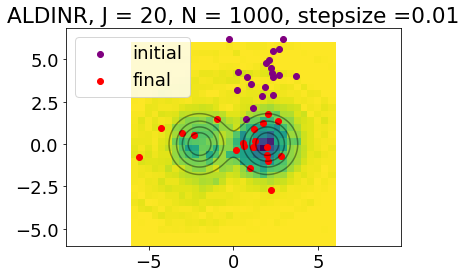


Experiment 5
(2, 20)
ULA: 22.261651039123535 seconds
ALDI with gradient: 23.163047075271606 seconds
iter
0
lambda min
0.7326438645891321
iter
500
lambda min
0.5825043354563975
ALDI NR: 23.812397956848145 seconds


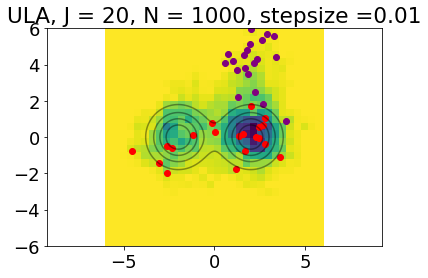

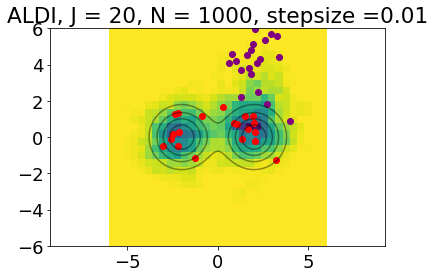

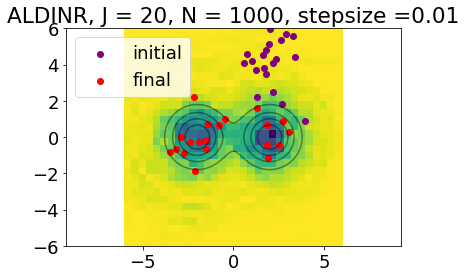


Experiment 5
(2, 20)
ULA: 22.868420124053955 seconds
ALDI with gradient: 23.87010884284973 seconds
iter
0
lambda min
0.6388695714420383
iter
500
lambda min
2.51998151558553


/var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_25757/1689426094.py:37: RuntimeWarning: overflow encountered in double_scalars
  gradient= -  (1/(bimodal_distribution(z)))*(0.5*pdf1*np.matmul(np.linalg.inv(cov1),(z - mean1))\


ValueError: array must not contain infs or NaNs

In [20]:

plt.figure()
DS = plt.contour(U0, U1, dens) # plot normalized density  
plt.clabel(DS, inline=1, fontsize=10)
labels = ['post', 'post','post','post','post', 'post']
for i in range(len(labels)):
    DS.collections[i].set_label(labels[i])
plt.axis('equal')

# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 1000 # number of iterations
d = 2 # dimension
tau = 1e-2 # step size

# parameters of our algorithm
const = 1.5 


N_exp = 50

for j in range(N_exp):
    
    print()
    print("Experiment "+str(j))
    # resample initialization
    mean_init = np.asarray([2,4])
    cov_init = [[1, 0], [0, 2]]
    u0 = np.random.multivariate_normal(mean_init, cov_init, J).T
    print(u0.shape)#np.random.normal(0,1.0,(d,J)) 


    # ULA
    start_time = time.time()
    us_list_ULA = run_ULA_mog(I, N_sim, u0, tau)
    np.save('save_data/mog/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
            +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")

    # ALDI 
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient_mog(I, N_sim, u0, tau)
    np.save('save_data/mog/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                        +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")

    # NRALDI (our scheme)
    # eventually new parameters like stepsize

    tau_ALDINR = tau
    start_time = time.time()
    us_list_ALDINR = run_ALDINR_mog(I, N_sim, u0, tau_ALDINR, const) 
    np.save('save_data/mog/ALDINR_J_'\
                          +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)


    print(f"ALDI NR: {time.time()-start_time} seconds")
    
    # plot results
    
    val_min = min(( np.min(us_list_ULA), np.min(us_list_ALDI)))
    val_max = max(( np.max(us_list_ULA), np.max(us_list_ALDI)))

    name = nameof(us_list_ULA).lstrip('us_list')
    plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0],  color = "purple", label = 'initial')
    plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')


    name = nameof(us_list_ALDI).lstrip('us_list')
    plot_results(I, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red", label = 'final')

    name = nameof(us_list_ALDINR).lstrip('us_list')
    plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()



In [21]:
# compute means and covariances

J = us_list_ULA.shape[1]
N_sim = us_list_ULA.shape[2]


means_ULA = np.mean(us_list_ULA, axis = 1)
means_ALDI = np.mean(us_list_ALDI, axis = 1)
means_ALDINR = np.mean(us_list_ALDINR, axis = 1)


covariances_ULA = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J
 
covariances_ALDI = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

covariances_ALDINR = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J

Text(0.5, 1.0, 'Distance to mean (|| mean(particles) - mean(target)||)')

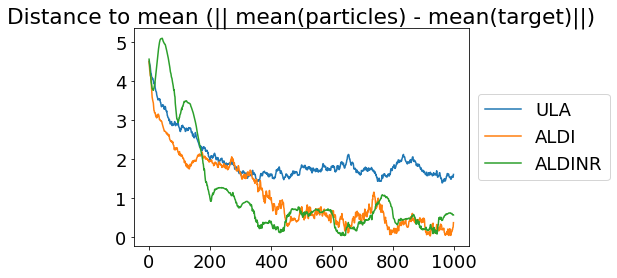

In [22]:
distances_to_mean_ULA = np.linalg.norm(means_ULA, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR, axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distance to mean (|| mean(particles) - mean(target)||)')

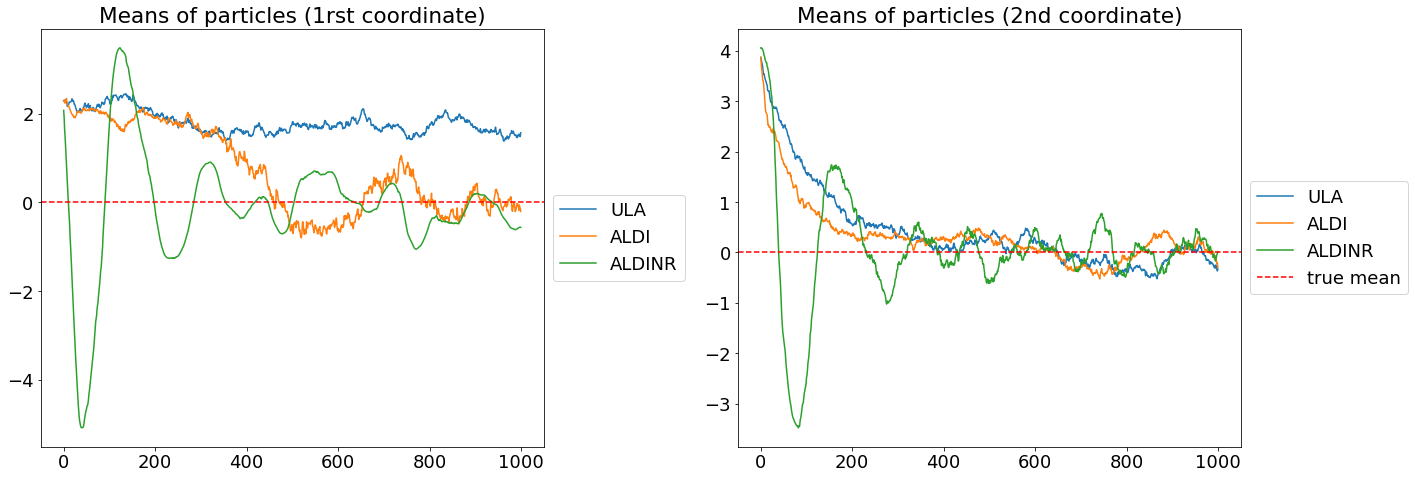

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(7)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)

plt.plot(means_ULA[0, :], label = 'ULA' )
plt.plot(means_ALDI[0, :], label = 'ALDI' )
plt.plot(means_ALDINR[0, :], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(means_ULA[1, :], label = 'ULA' )
plt.plot(means_ALDI[1, :], label = 'ALDI' )
plt.plot(means_ALDINR[1, :], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (2nd coordinate)')
plt.tight_layout()

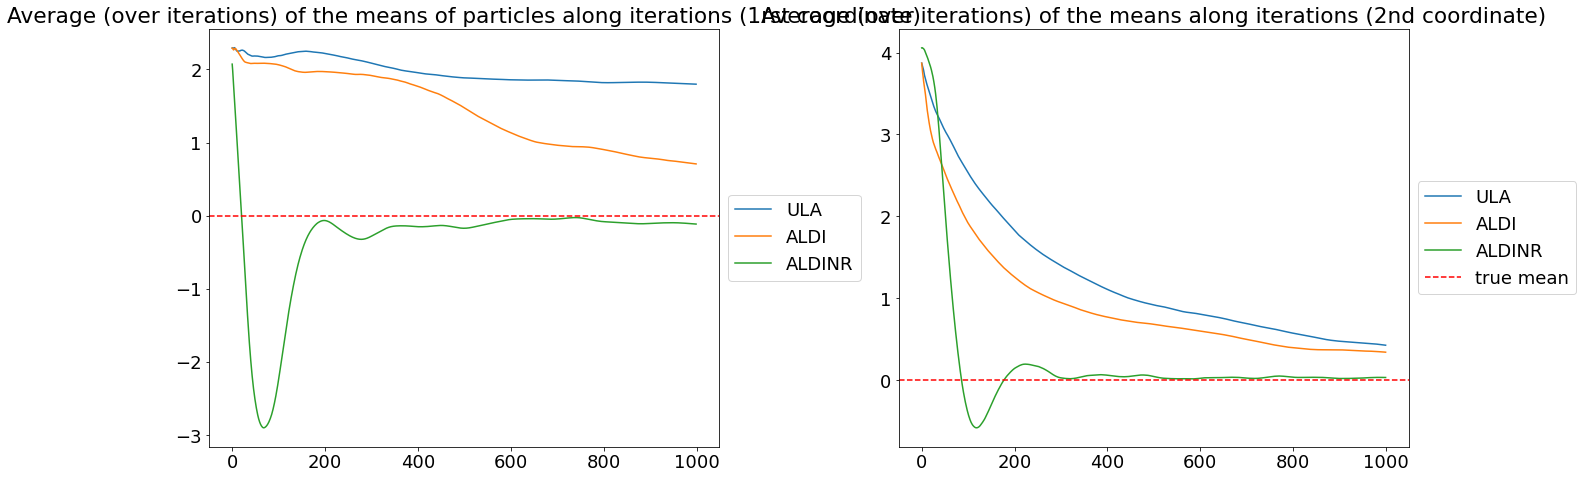

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(7)
fig.set_figwidth(20)


average_means_ULA = np.asarray([np.mean(means_ULA[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR[:, :i], axis = 1) for i in range(1, N_sim + 1)])

plt.subplot(1, 2, 1)
plt.plot(average_means_ULA[:, 0], label = 'ULA' )
plt.plot(average_means_ALDI[:, 0], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 0], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Average (over iterations) of the means of particles along iterations (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(average_means_ULA[:, 1], label = 'ULA' )
plt.plot(average_means_ALDI[:, 1], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 1], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Average (over iterations) of the means along iterations (2nd coordinate)')
plt.tight_layout()

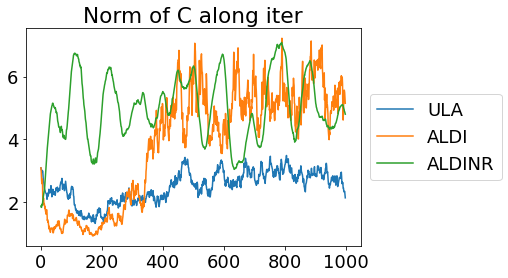

In [25]:
distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C along iter')
plt.show()

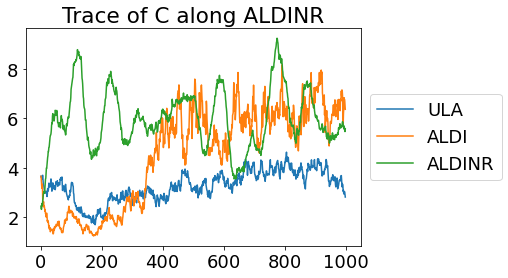

In [26]:
traces_of_C_ULA = np.asarray([np.trace(covariances_ULA[:, :, i]) for  i in range(covariances_ULA.shape[2])] )
traces_of_C_ALDI = np.asarray([np.trace(covariances_ALDI[:, :, i]) for  i in range(covariances_ALDI.shape[2])] )
traces_of_C_ALDINR = np.asarray([np.trace(covariances_ALDINR[:, :, i]) for  i in range(covariances_ALDINR.shape[2])] )

plt.plot(traces_of_C_ULA, label ='ULA')
plt.plot(traces_of_C_ALDI, label ='ALDI')
plt.plot(traces_of_C_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Trace of C along ALDINR')
plt.show()

### marginal of distribution of particles on last iterations

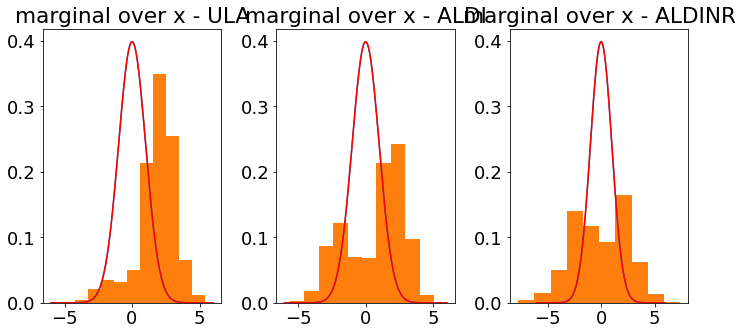

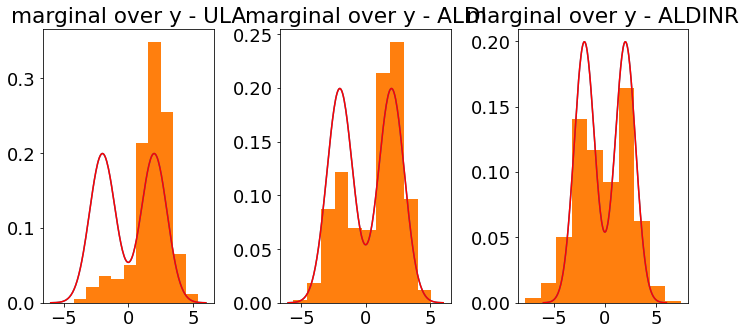

In [29]:
binsx = np.linspace(xmin,xmax,31)
binsy = np.linspace(ymin,ymax,31)

# marginal over x

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1,3,1)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ULA[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ULA')

plt.subplot(1,3,2)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ALDI[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ALDI')

plt.subplot(1,3,3)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ALDINR[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ALDINR')
fig.tight_layout()

# marginal over y

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1,3,1)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ULA[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ULA')

plt.subplot(1,3,2)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ALDI[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ALDI')

plt.subplot(1,3,3)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ALDINR[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ALDINR')
plt.tight_layout()

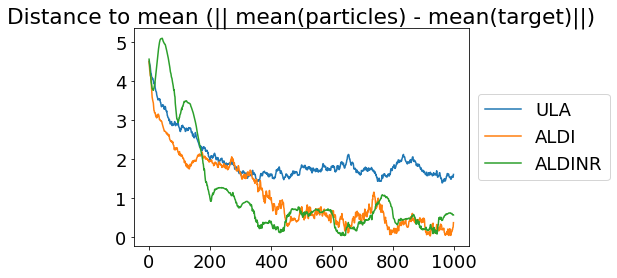

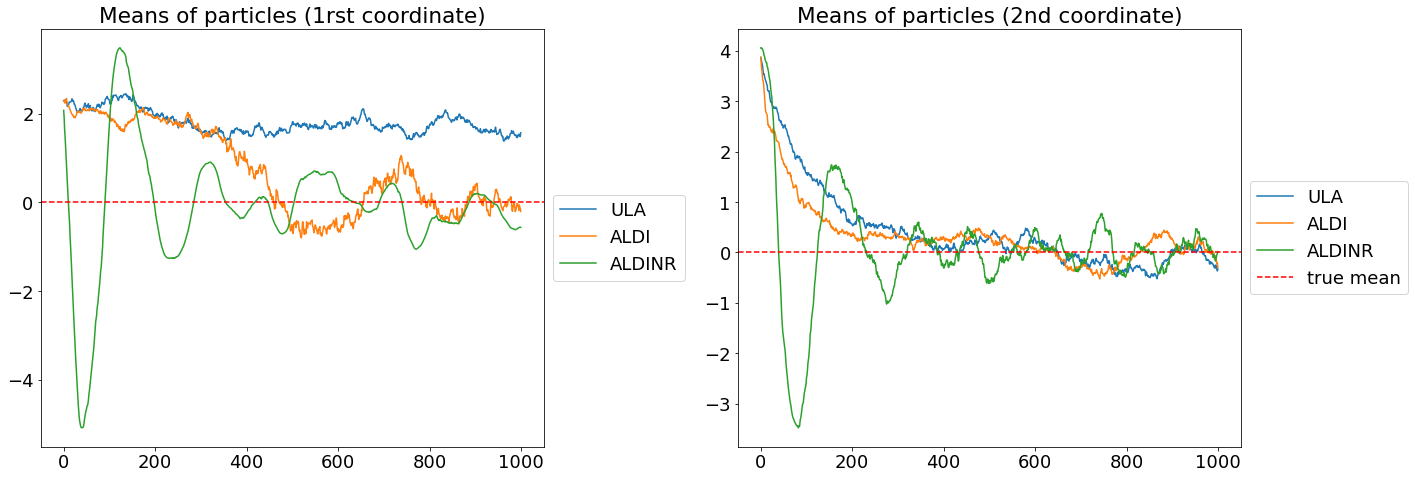

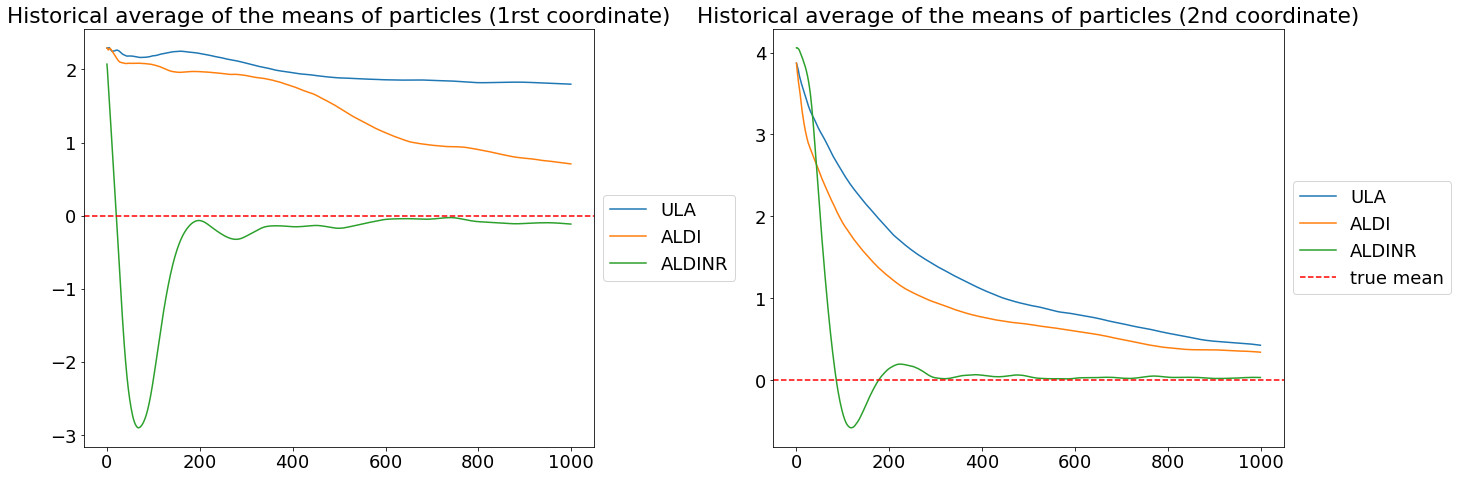

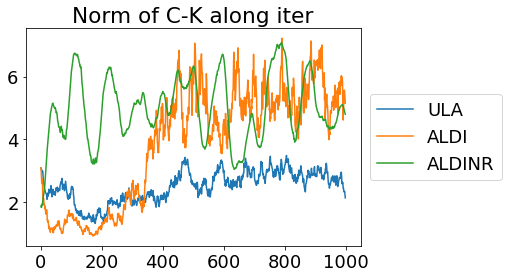

In [30]:
j = 0

# load data

# compute means and covariances
J = us_list_ULA.shape[1]
N_sim = us_list_ULA.shape[2]


means_ULA = np.mean(us_list_ULA, axis = 1)
means_ALDI = np.mean(us_list_ALDI, axis = 1)
means_ALDINR = np.mean(us_list_ALDINR, axis = 1)

covariances_ULA = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J
 
covariances_ALDI = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

covariances_ALDINR = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J
    
# plot distances to target mean
distances_to_mean_ULA = np.linalg.norm(means_ULA, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR, axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distance to mean (|| mean(particles) - mean(target)||)')

# plot means of particles along iterations

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(7)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)
plt.plot(means_ULA[0, :], label = 'ULA' )
plt.plot(means_ALDI[0, :], label = 'ALDI' )
plt.plot(means_ALDINR[0, :], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(means_ULA[1, :], label = 'ULA' )
plt.plot(means_ALDI[1, :], label = 'ALDI' )
plt.plot(means_ALDINR[1, :], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (2nd coordinate)')
plt.tight_layout()
plt.show()

# plot historical average (i.e. over iterations) of means of particles

average_means_ULA = np.asarray([np.mean(means_ULA[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR[:, :i], axis = 1) for i in range(1, N_sim + 1)])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
#fig.set_figheight(7)
#fig.set_figwidth(20)

plt.subplot(1, 2, 1)
plt.plot(average_means_ULA[:, 0], label = 'ULA' )
plt.plot(average_means_ALDI[:, 0], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 0], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Historical average of the means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(average_means_ULA[:, 1], label = 'ULA' )
plt.plot(average_means_ALDI[:, 1], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 1], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Historical average of the means of particles (2nd coordinate)')
plt.tight_layout()
plt.show()

distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C-K along iter')
plt.show()

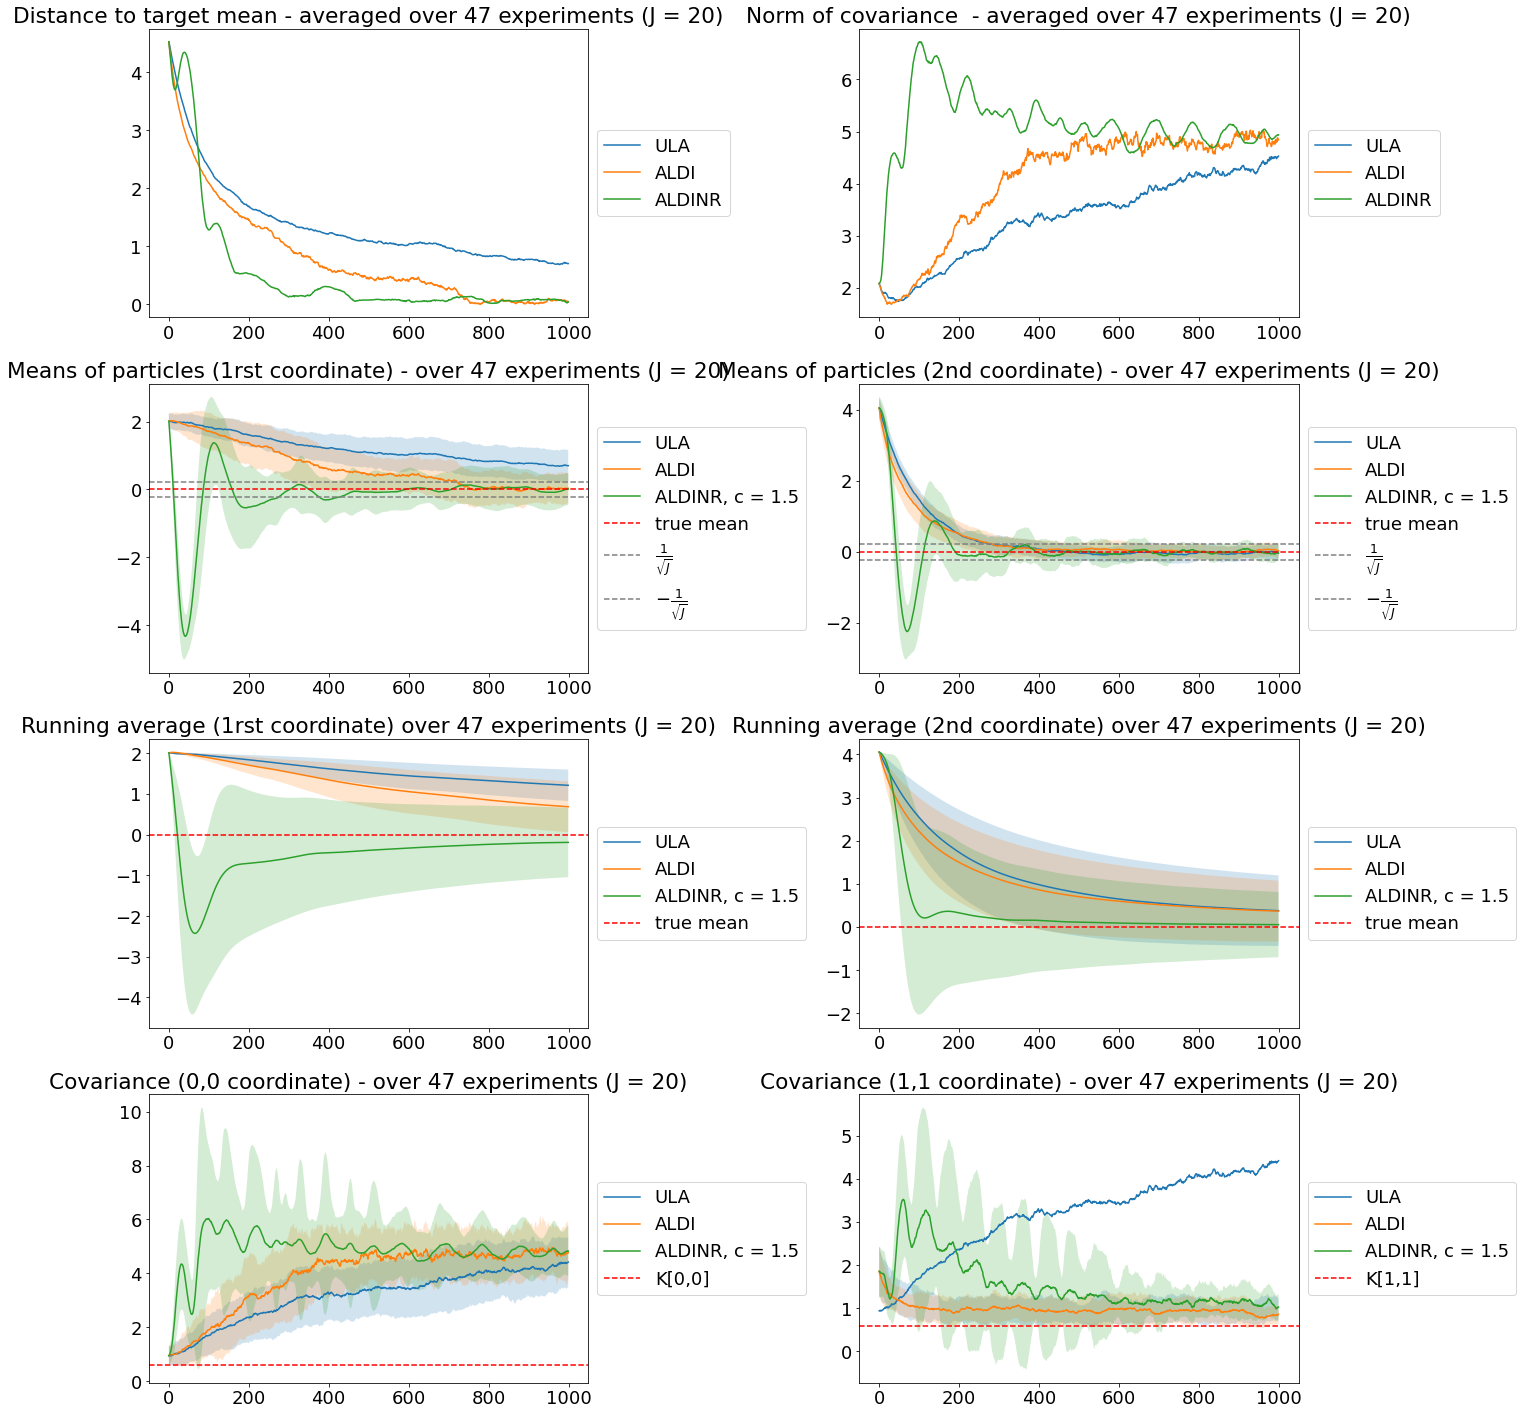

In [35]:

# aggregate vector over experiments
means_ULA_all = np.zeros((d, N_sim, N_exp))
means_ALDI_all = np.zeros((d, N_sim, N_exp))
means_ALDINR_all = np.zeros((d, N_sim, N_exp))

covariances_ULA_all = np.zeros((d, d, N_sim, N_exp))
covariances_ALDI_all = np.zeros((d, d, N_sim, N_exp))
covariances_ALDINR_all = np.zeros((d, d, N_sim, N_exp))

N_exp = 47

for j in range(N_exp):

    # load data
    us_list_ULA = np.load('save_data/mog_gap_4_sigma_1_badinit/ULA_J_20_Nsim_1000_tau_0.01_Exp_'+str(j)+'.npy')
    us_list_ALDI = np.load('save_data/mog_gap_4_sigma_1_badinit/ALDI_J_20_Nsim_1000_tau_0.01_Exp_'+str(j)+'.npy')
    my_file = 'save_data/mog_gap_4_sigma_1_badinit/ALDINR_J_20_Nsim_1000_tau_0.01_Exp_'+str(j)+'.npy'
    us_list_ALDINR = np.load(my_file)
    #const = re.findall(re.escape('c_')+"(.*)"+re.escape('_J'),my_file)[0]

    # compute means and covariances
    d = us_list_ULA.shape[0]
    J = us_list_ULA.shape[1]
    N_sim = us_list_ULA.shape[2]


    # single vectors
    means_ULA = np.mean(us_list_ULA, axis = 1)
    means_ALDI = np.mean(us_list_ALDI, axis = 1)
    means_ALDINR = np.mean(us_list_ALDINR, axis = 1)

    means_ULA_all[:, :, j] = means_ULA
    means_ALDI_all[:, :, j] = means_ALDI
    means_ALDINR_all[:, :, j] = means_ALDINR

    covariances_ULA = np.ones((d, d, N_sim))
    for i in range(N_sim):
        covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J

    covariances_ALDI = np.ones((d, d, N_sim))
    for i in range(N_sim):
        covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

    covariances_ALDINR = np.ones((d, d, N_sim))
    for i in range(N_sim):
        covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J

    covariances_ULA_all[:, :, :, j] = covariances_ULA
    covariances_ALDI_all[:, :, :, j] = covariances_ALDI
    covariances_ALDINR_all[:, :, :, j] = covariances_ALDINR



# average (over N_exp) the means
means_ULA_over_exp = np.mean(means_ULA_all, axis = 2)
means_ALDI_over_exp = np.mean(means_ALDI_all, axis = 2)
means_ALDINR_over_exp = np.mean(means_ALDINR_all, axis = 2)

# here: put std

# average (over N_exp) the covariances
covariances_ULA_over_exp = np.mean(covariances_ULA_all, axis = 3)
covariances_ALDI_over_exp = np.mean(covariances_ALDI_all, axis = 3)
covariances_ALDINR_over_exp = np.mean(covariances_ALDINR_all, axis = 3)



#### PLOTS


# plot distances to target mean
fig, axes = plt.subplots(nrows = 4, ncols = 2)
fig.set_figheight(20)
fig.set_figwidth(20)

plt.subplot(4, 2, 1)
distances_to_mean_ULA = np.linalg.norm(means_ULA_over_exp, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI_over_exp, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR_over_exp, axis=0)
#plt.plot(distances_to_mean_ALDINR, label = 'ALDINR, c = '+str(const)) 
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR') 

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distance to target mean - averaged over '+str(N_exp)+' experiments (J = '+str(J)+')')

# plot norm of covariances
plt.subplot(4, 2, 2)
distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA_over_exp[:, :, i]) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI_over_exp[:, :, i]) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR_over_exp[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
#plt.plot(distances_to_covariances_ALDINR, label ='ALDINR, c = '+str(const))
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of covariance  - averaged over '+str(N_exp)+' experiments (J = '+str(J)+')')


# plot means of particles along iterations
plt.subplot(4, 2, 3)
plt.plot(range(N_sim), means_ULA_over_exp[0, :], label = 'ULA' )
error =  np.asarray(np.std(means_ULA_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
error_ax1 =  error[0, :] # shape (1, 3000)
plt.fill_between(range(N_sim), means_ULA_over_exp[0, :] - error_ax1, means_ULA_over_exp[0, :] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), means_ALDI_over_exp[0, :], label = 'ALDI' )
error =  np.asarray(np.std(means_ALDI_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
error_ax1 =  error[0, :] # shape (1, 3000)
plt.fill_between(range(N_sim), means_ALDI_over_exp[0, :] - error_ax1, means_ALDI_over_exp[0, :] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), means_ALDINR_over_exp[0, :], label = 'ALDINR, c = '+str(const))
error =  np.asarray(np.std(means_ALDINR_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
error_ax1 =  error[0, :] # shape (1, 3000)
plt.fill_between(range(N_sim), means_ALDINR_over_exp[0, :] - error_ax1, means_ALDINR_over_exp[0, :] + error_ax1, alpha=0.2)

plt.axhline(y = 0, color='r', linestyle='--', label ='true mean')
plt.axhline(y = 1/np.sqrt(J), color='gray', linestyle='--', label = r'$\frac{1}{\sqrt{J}}$')
plt.axhline(y = -1/np.sqrt(J), color='gray', linestyle='--', label = r'$ - \frac{1}{\sqrt{J}}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (1rst coordinate) - over '+str(N_exp)+' experiments (J = '+str(J)+')')

plt.subplot(4, 2, 4)
plt.plot(range(N_sim), means_ULA_over_exp[1, :], label = 'ULA' )
error =  np.asarray(np.std(means_ULA_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
error_ax1 =  error[1, :] # shape (1, 3000)
plt.fill_between(range(N_sim), means_ULA_over_exp[1, :] - error_ax1, means_ULA_over_exp[1, :] + error_ax1, alpha=0.2)

plt.plot(means_ALDI_over_exp[1, :], label = 'ALDI' )
error =  np.asarray(np.std(means_ALDI_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
error_ax1 =  error[1, :] # shape (1, 3000)
plt.fill_between(range(N_sim), means_ALDI_over_exp[1, :] - error_ax1, means_ALDI_over_exp[1, :] + error_ax1, alpha=0.2)

plt.plot(means_ALDINR_over_exp[1, :], label = 'ALDINR, c = '+str(const))
error =  np.asarray(np.std(means_ALDINR_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
error_ax1 =  error[1, :] # shape (1, 3000)
plt.fill_between(range(N_sim), means_ALDINR_over_exp[1, :] - error_ax1, means_ALDINR_over_exp[1, :] + error_ax1, alpha=0.2)

plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.axhline(y = 1/np.sqrt(J), color='gray', linestyle='--', label = r'$\frac{1}{\sqrt{J}}$')
plt.axhline(y = -1/np.sqrt(J), color='gray', linestyle='--', label = r'$ - \frac{1}{\sqrt{J}}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (2nd coordinate) - over '+str(N_exp)+' experiments (J = '+str(J)+')')


# plot running average
average_means_ULA = np.asarray([np.mean(means_ULA_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)])

plt.subplot(4, 2, 5)
plt.plot(range(N_sim), average_means_ULA[:, 0], label = 'ULA' )
error =  np.asarray([np.std(means_ULA_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
error_ax1 =  error[0, :] # shape (1, 3000)
plt.fill_between(range(N_sim), average_means_ULA[:, 0] - error_ax1, average_means_ULA[:, 0] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), average_means_ALDI[:, 0], label = 'ALDI' )
error =  np.asarray([np.std(means_ALDI_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
error_ax1 =  error[0, :] # shape (1, 3000)
plt.fill_between(range(N_sim), average_means_ALDI[:, 0] - error_ax1, average_means_ALDI[:, 0] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), average_means_ALDINR[:, 0], label = 'ALDINR, c = '+str(const))
error =  np.asarray([np.std(means_ALDINR_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
error_ax1 =  error[0, :] # shape (1, 3000)
plt.fill_between(range(N_sim), average_means_ALDINR[:, 0] - error_ax1, average_means_ALDINR[:, 0] + error_ax1, alpha=0.2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Running average (1rst coordinate) over '+str(N_exp)+' experiments (J = '+str(J)+')')

plt.subplot(4, 2, 6)
plt.plot(range(N_sim), average_means_ULA[:, 1], label = 'ULA' )
error =  np.asarray([np.std(means_ULA_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
error_ax1 =  error[1, :] # shape (1, 3000)
plt.fill_between(range(N_sim), average_means_ULA[:, 1] - error_ax1, average_means_ULA[:, 1] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), average_means_ALDI[:, 1], label = 'ALDI' )
error =  np.asarray([np.std(means_ALDI_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
error_ax1 =  error[1, :] # shape (1, 3000)
plt.fill_between(range(N_sim), average_means_ALDI[:, 1] - error_ax1, average_means_ALDI[:, 1] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), average_means_ALDINR[:, 1], label = 'ALDINR, c = '+str(const))
error =  np.asarray([np.std(means_ALDINR_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
error_ax1 =  error[1, :] # shape (1, 3000)
plt.fill_between(range(N_sim), average_means_ALDINR[:, 1] - error_ax1, average_means_ALDINR[:, 1] + error_ax1, alpha=0.2)

plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Running average (2nd coordinate) over '+str(N_exp)+' experiments (J = '+str(J)+')')


#  plot covariance estimate coordinate by coordinate (4 coordinates)


plt.subplot(4, 2, 7)

plt.plot(range(N_sim), covariances_ULA_over_exp[0, 0, :], label = 'ULA' )
error =  np.std(covariances_ULA_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
error_ax1 =  error[0, 0, :]
plt.fill_between(range(N_sim), covariances_ULA_over_exp[0, 0, :] - error_ax1, covariances_ULA_over_exp[0, 0, :] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), covariances_ALDI_over_exp[0, 0, :], label = 'ALDI' )
error =  np.std(covariances_ALDI_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
error_ax1 =  error[0, 0, :]
plt.fill_between(range(N_sim), covariances_ALDI_over_exp[0, 0, :] - error_ax1, covariances_ALDI_over_exp[0, 0, :] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), covariances_ALDINR_over_exp[0, 0, :], label = 'ALDINR, c = '+str(const) )
error =  np.std(covariances_ALDINR_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
error_ax1 =  error[0, 0, :]
plt.fill_between(range(N_sim), covariances_ALDINR_over_exp[0, 0, :] - error_ax1, covariances_ALDINR_over_exp[0, 0, :] + error_ax1, alpha=0.2)

plt.axhline(y = 0.6, color='r', linestyle='--', label ='K[0,0]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Covariance (0,0 coordinate) - over '+str(N_exp)+' experiments (J = '+str(J)+')')

plt.subplot(4, 2, 8)

plt.plot(range(N_sim), covariances_ULA_over_exp[0, 0, :], label = 'ULA' )
error =  np.std(covariances_ULA_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
error_ax1 =  error[1, 1, :]
plt.fill_between(range(N_sim), covariances_ULA_over_exp[1, 1, :] - error_ax1, covariances_ULA_over_exp[1, 1, :] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), covariances_ALDI_over_exp[1, 1, :], label = 'ALDI' )
error =  np.std(covariances_ALDI_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
error_ax1 =  error[1, 1, :]
plt.fill_between(range(N_sim), covariances_ALDI_over_exp[1, 1, :] - error_ax1, covariances_ALDI_over_exp[1, 1, :] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), covariances_ALDINR_over_exp[1, 1, :], label = 'ALDINR, c = '+str(const) )
error =  np.std(covariances_ALDINR_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
error_ax1 =  error[1, 1, :]
plt.fill_between(range(N_sim), covariances_ALDINR_over_exp[1, 1, :] - error_ax1, covariances_ALDINR_over_exp[1, 1, :] + error_ax1, alpha=0.2)

plt.axhline(y = 0.6, color='r', linestyle='--', label ='K[1,1]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Covariance (1,1 coordinate) - over '+str(N_exp)+' experiments (J = '+str(J)+')')
plt.tight_layout()
plt.savefig('MOG_example_statistics_ALDINR_c_'+str(const)+'.pdf')
plt.show()


### to do : add step size in title